<a href="https://colab.research.google.com/github/TonioFlag/Teoria-de-Colas-y-Simulacion/blob/main/Caso-3/Analisis-de-entrada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pingouin
!pip install distfit

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import pingouin as pg
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from distfit import distfit
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

#Lectura de la base

In [ ]:
arribo=pd.read_excel('/content/drive/MyDrive/Actual/COLAS/Tasas de arribo.xlsx')

num=[]
for i in arribo['dia']:
  if i=="Lunes":
    num.append(1)
  elif i=="Martes":
    num.append(2)
  elif i=="Miercoles":
    num.append(3)
  elif i=="Jueves":
    num.append(4)
  elif i=="Sabado":
    num.append(6)
  elif i=="Viernes":
    num.append(5)
  elif i=="Domingo":
    num.append(7)

arribo['num_dia']=num

intervalos=5
amplitud=arribo.min_cliente.max()-arribo.min_cliente.min()
intervalo=amplitud/5
clasificacion=[]
for i in arribo.min_cliente:
  if i <= intervalo: clasificacion.append(1)
  elif i <= 2*intervalo: clasificacion.append(2)
  elif i <= 3*intervalo: clasificacion.append(3)
  elif i <= 4*intervalo: clasificacion.append(4)
  elif i <= 5*intervalo: clasificacion.append(5)

arribo['clase']=clasificacion


arribo['Llegada']=pd.to_datetime(arribo['Llegada'],format='%H:%M:%S')

intervalos = [(6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22)]
es=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

def asignar_intervalo(hora):
    for i in range(len(intervalos)):
        if intervalos[i][0] <= hora.hour < intervalos[i][1]:
            return es[i]

arribo['intervalo'] = arribo['Llegada'].apply(asignar_intervalo)

meses_dict = {'Abril': 4, 'Septiembre': 9,'Noviembre': 11}
arribo['num_mes'] = arribo['Mes'].map(meses_dict)
servicios=list(arribo['TipoServ.'].unique())
servicio = {servicios[0]: 1, servicios[1]: 2,servicios[2]: 3,servicios[3]: 4,servicios[4]: 5}
arribo['tipo_serv'] = arribo['TipoServ.'].map(servicio)

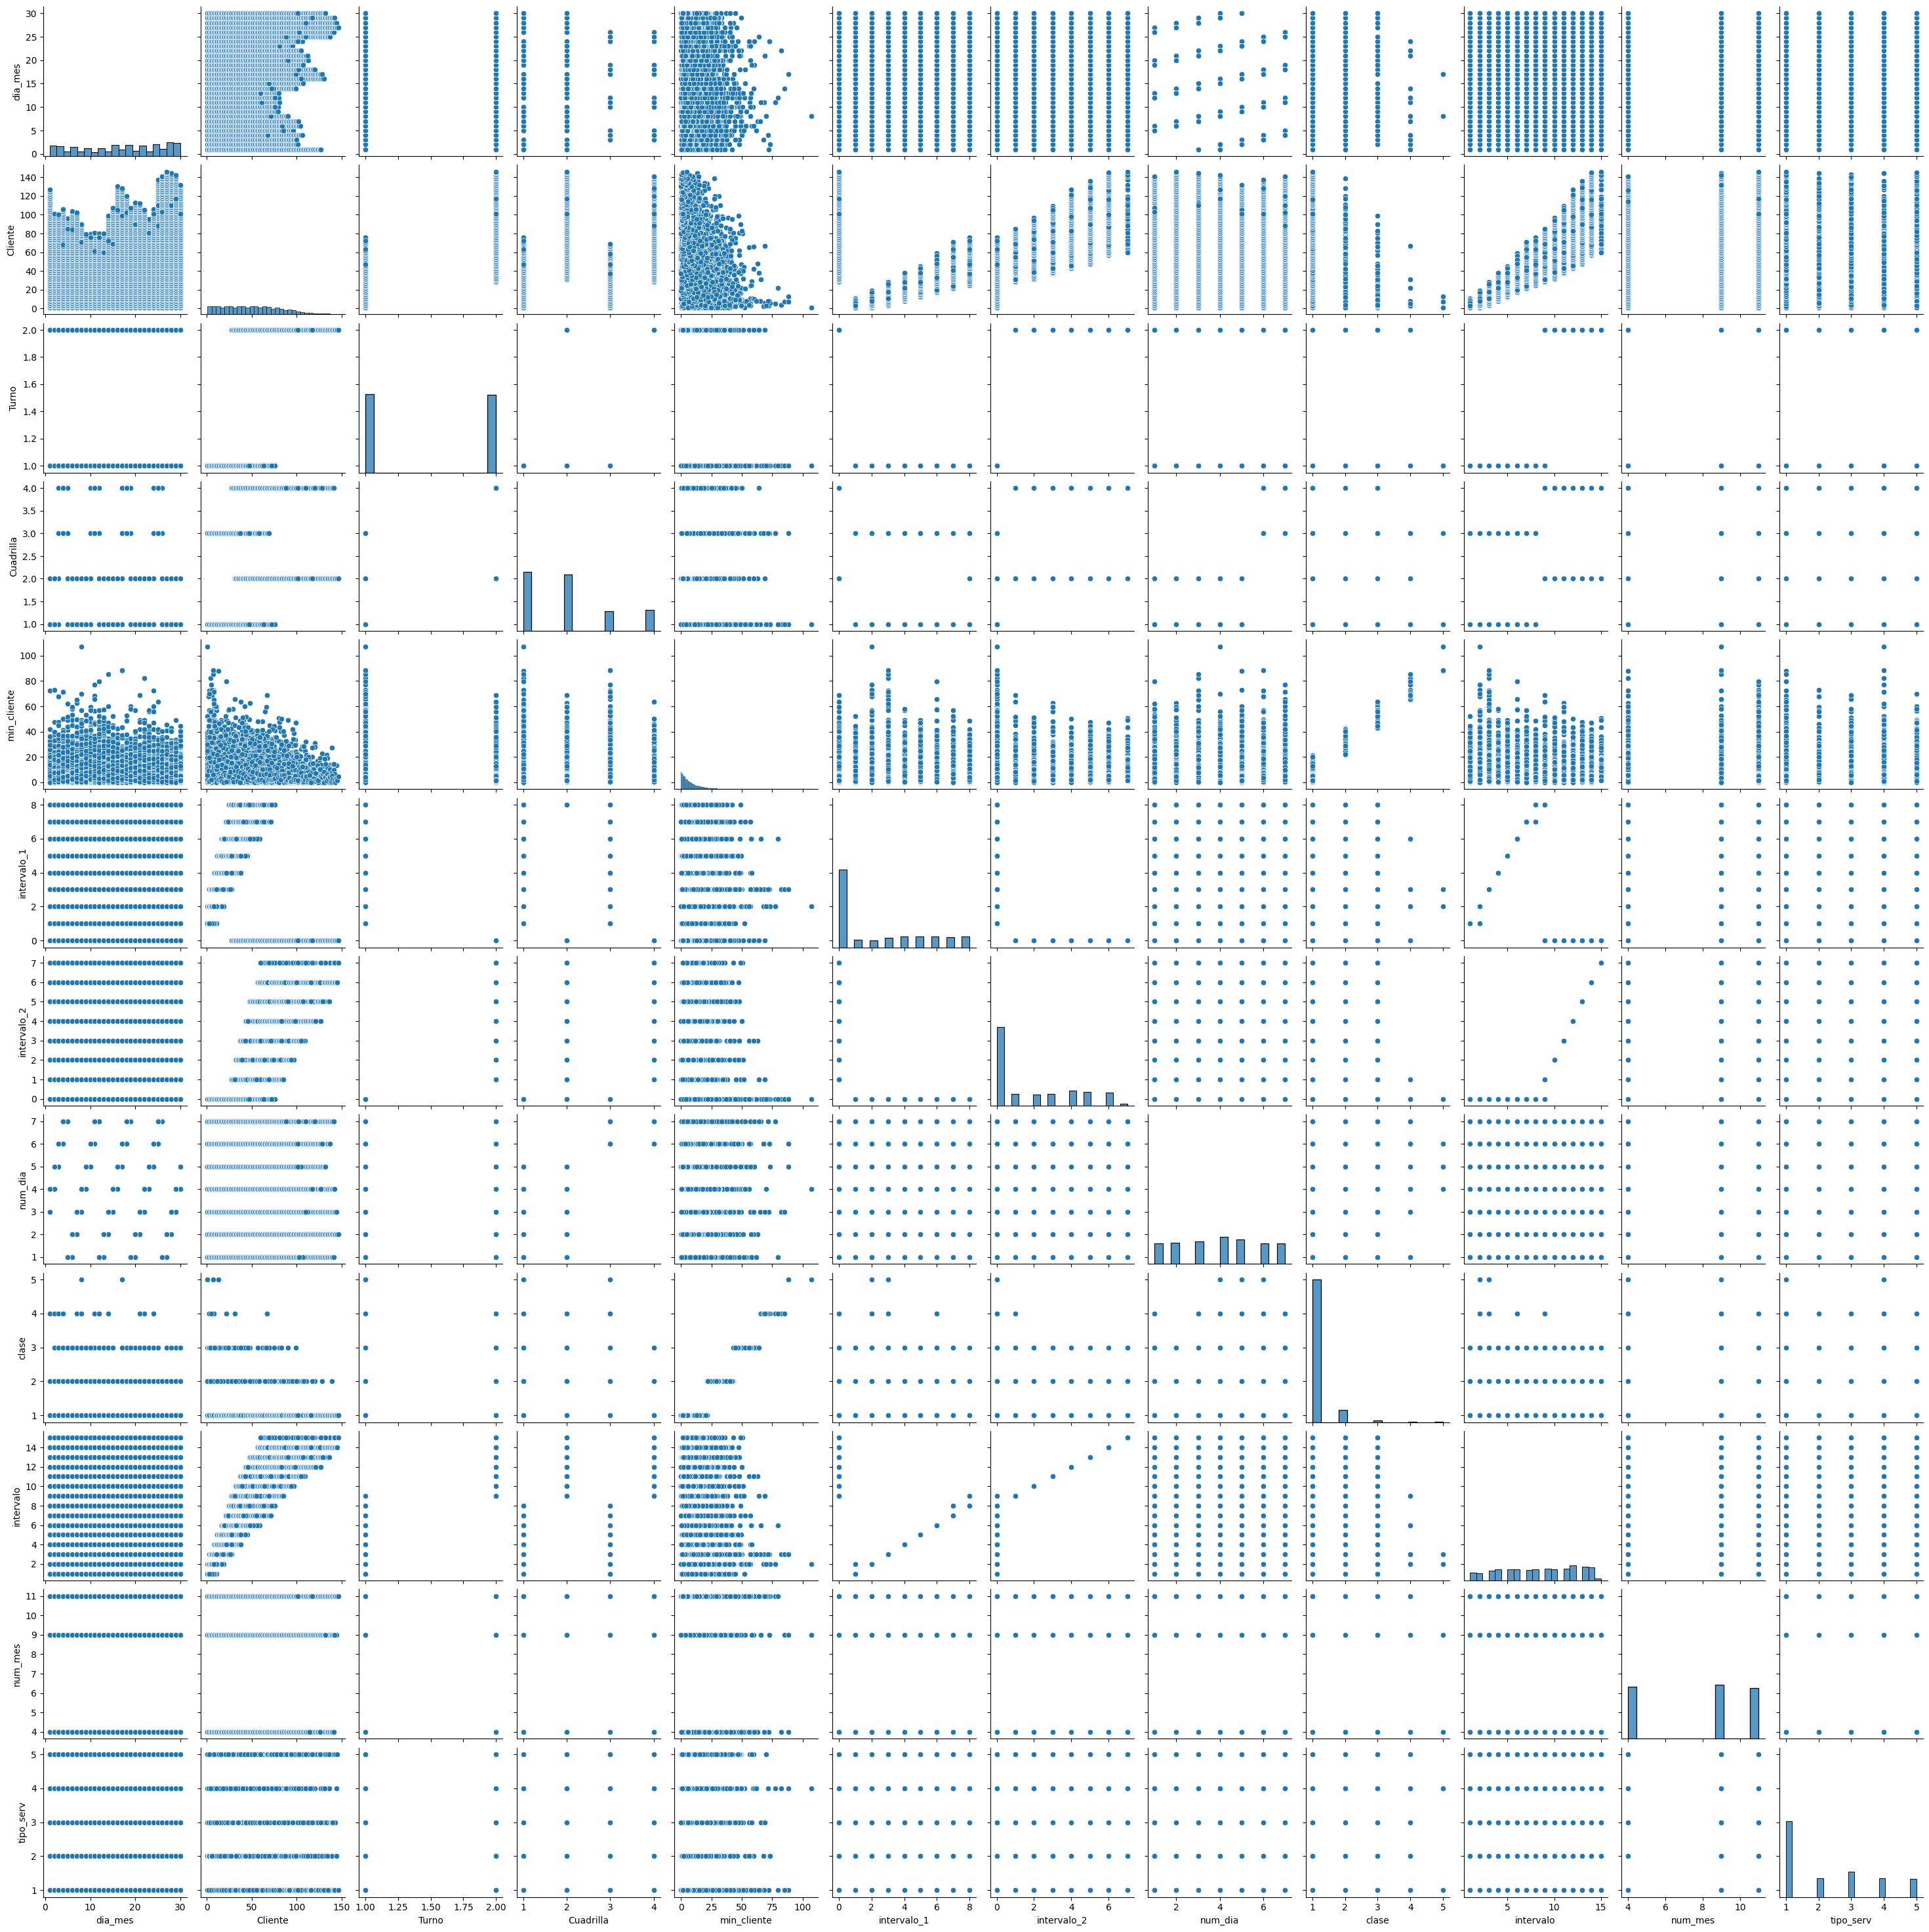

In [ ]:
sns.pairplot(arribo)

In [ ]:
arribo=arribo.drop(columns=['intervalo_1','intervalo_2'],axis=1)
m=arribo.corr()

<Axes: >

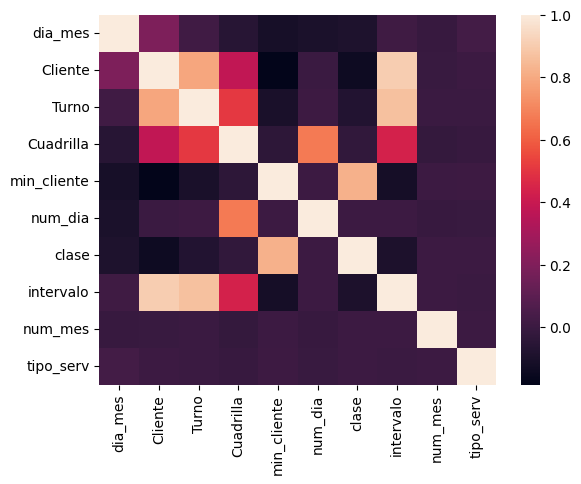

In [ ]:
sns.heatmap(m)

In [ ]:
var=arribo['min_cliente']
n=len(var)
m=var.mean()
d=var.std()
signi=0.95
alfa=(1-signi)/2
z=norm.ppf(alfa)
error=np.abs(z*(d/np.sqrt(n)))

print("El limite inferior para ")
print("Es "+str(m-error))
print("El limite superior para ")
print("Es "+str(m+error))

El limite inferior para 
Es 8.599033110134691
El limite superior para 
Es 8.996905038953699


#Funciones para automatizar gráficas, fit y otros.


##Para los kmeans

In [ ]:
def kmeans_eval(tur,grupos,filtro):

  kruskal,levene,pruebavar=pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
  arreglo, sorce, turno = [], [], []

  #Tratar turnos como lista incluso si es un solo número
  if not isinstance(tur, list):
    tur = [tur]

  # Tratar grupos como lista incluso si es un solo número
  if not isinstance(grupos, list):
    grupos = [grupos]

  for t in tur:
    base=arribo[(arribo['Turno']==t)]
    base=base.reset_index()
    X = np.array(base['min_cliente']).reshape(-1, 1)
    df=pd.DataFrame()

    for k in grupos:
      kmeans = KMeans(n_clusters=k, random_state=42)
      kmeans.fit(X)
      df[k] = kmeans.labels_

    cosas=["Mes","dia","TipoServ.","intervalo","Cuadrilla"]

    for k in list(df.columns):
      base['kmeans']=df[k]

      if filtro<16:
        kks=[]
        for i in range(len(base['kmeans'])):
          if filtro==base['intervalo'][i]:
            kks.append(base['kmeans'].max()+1)
          else:
            kks.append(base['kmeans'][i])
        base['kmeans']=kks

      for i in base['kmeans'].unique():
        eval=base[(base['kmeans']==i)]

        for j in cosas:
          if len(eval[j].unique())>1:
            mete=(k,i)
            sorce.append(j)
            turno.append(t)
            arreglo.append(mete)
            kruskal=pd.concat([kruskal,pg.kruskal(eval, dv='min_cliente', between=j)])
            levene=pd.concat([levene,pd.DataFrame(pg.homoscedasticity(eval, dv="min_cliente", group=j))])
            pruebavar=pd.concat([pruebavar,pg.homoscedasticity(eval, dv="min_cliente", group=j, method="bartlett", alpha=.05)])

  kruskal['grupo']=arreglo
  levene['grupo']=arreglo
  pruebavar['grupo']=arreglo
  kruskal['turno']=turno
  levene['turno']=turno
  pruebavar['turno']=turno
  result=[]
  for i in kruskal['p-unc']:
    if i<=5e-02:
      result.append(False)
    else:
      result.append(True)
  kruskal["Independencia"]=result
  levene['Source']=sorce
  pruebavar['Source']=sorce

  result_table = pd.concat([kruskal, levene, pruebavar])
  result_table = result_table.reset_index()

  return result_table

##Para gráficos de disperción que utilizan kmeans, pidiendo el turno y el numero de clusteres.

In [ ]:
def dispercion(tur,n_kluster):
  base=arribo[(arribo['Turno']==tur)]
  base=base.reset_index()
  X = np.array(base['min_cliente']).reshape(-1, 1)
  kmeans = KMeans(n_clusters=n_kluster, random_state=42)
  kmeans.fit(X)
  base['kmeans'] = kmeans.labels_

  plt.figure(figsize=(8, 6))

    # Iterar sobre los clústeres y visualizar la dispersión
  for evaluando in base['kmeans'].unique():
    cluster_data = base[base['kmeans'] == evaluando]
    x = len(cluster_data) - 1
    plt.scatter(cluster_data['min_cliente'][:x],
                cluster_data['min_cliente'][1:],
                label=f'Cluster {evaluando}',
                s=8,
                alpha=0.7)

    # Configurar etiquetas y leyenda
  plt.xlabel("Tiempo de llegada (Xi)")
  plt.ylabel("Tiempo de llegada siguiente (Xi+1)")
  plt.title(f"Scatter plot de tiempos de arribo - Turno {tur}")
  plt.legend(title="Cluster")

    # Mostrar el gráfico
  plt.show()

##Clusters en 1D con la libreria plt

In [ ]:
def grafica1d(turno,clus):
  base=arribo[(arribo['Turno']==turno)]
  x=range(len(base['min_cliente'])-1)
  par=[]
  for i in x:
    mete=(base['min_cliente'].iloc[i],base['min_cliente'].iloc[i+1])
    par.append(mete)
  X=np.array(par).reshape(-1,1)

  reduced_data = PCA(n_components=1).fit_transform(X)
  kmeans = KMeans(init="k-means++", n_clusters=clus, n_init=4)
  kmeans.fit(reduced_data)

  reduced_data = PCA(n_components=1).fit_transform(X)

  # Aplicar K-means
  kmeans = KMeans(init="k-means++", n_clusters=clus, n_init=4)
  kmeans.fit(reduced_data)

  # Visualización
  # Visualización
  plt.figure(figsize=(8, 6))

  # Scatter plot de los datos originales
  plt.scatter(reduced_data, np.zeros_like(reduced_data), c=kmeans.labels_, cmap='viridis', s=50, edgecolors='k', alpha=0.6)

  # Scatter plot de los centroides
  centroids = kmeans.cluster_centers_
  plt.scatter(centroids, np.zeros_like(centroids), marker="x", s=200, linewidths=3, color="r", zorder=10)

  plt.title("K-means clustering on 1D data para el turno "+str(turno)+"\n las X marcan los clusters")
  plt.xlabel("Tiempo de llegada (Xi)")
  plt.show()

##Para sacar las pruebas fit



In [ ]:
def fit(turno,ncluster,filtro):
  base=arribo[(arribo['Turno']==turno)]
  base=base.reset_index()
  X = np.array(base['min_cliente']).reshape(-1, 1)
  kmeans = KMeans(n_clusters=ncluster, random_state=42)
  kmeans.fit(X)
  base['kmeans'] = kmeans.labels_

  base=base[(base['intervalo']!=filtro)]
  base=base.reset_index()

  with pd.ExcelWriter("distribuciones.xlsx", engine='openpyxl') as writer:
        for i in base['kmeans'].unique():
            dfit = distfit()
            results2 = dfit.fit_transform(base[(base['kmeans'] == i)]['min_cliente'])

            # Guardar en diferentes hojas del mismo archivo Excel
            sheet_name = "grupo_" + str(i)
            results2['summary'].to_excel(writer, sheet_name=sheet_name)

            dfit.plot()

##Sacando el procentaje de participación y los datos que representa

In [ ]:
def exportarinfo(turno,ncluster,filtro):


  base=arribo[(arribo['Turno']==turno)]
  base=base.reset_index()
  X = np.array(base['min_cliente']).reshape(-1, 1)
  kmeans = KMeans(n_clusters=ncluster, random_state=42)
  kmeans.fit(X)
  base['kmeans'] = kmeans.labels_

  base=base[(base['intervalo']!=filtro)]
  base=base.reset_index()

  cosas=["Mes","dia","TipoServ.","Servidor","Cuadrilla","intervalo"]

  with pd.ExcelWriter("informacion.xlsx") as writer:
        for i in cosas:
            crosstab_result = pd.crosstab(base['kmeans'], base[i])
            normalized_result = pd.crosstab(base['kmeans'], base[i], normalize='index')
            export = pd.concat([crosstab_result, normalized_result], keys=['Count', 'Percentage'])
            export.to_excel(writer, sheet_name=i)

In [ ]:
exportarinfo(1,5,1000)

In [ ]:
exportarinfo(2,2,15)

In [ ]:
base=arribo[(arribo['intervalo']==15)]
cosas=["Mes","dia","TipoServ.","Servidor","Cuadrilla","intervalo"]
with pd.ExcelWriter("informacion_intervalo_15.xlsx") as writer:
  for i in cosas:
    crosstab_result = pd.crosstab(base['intervalo'], base[i])
    normalized_result = pd.crosstab(base['intervalo'], base[i], normalize='index')
    export = pd.concat([crosstab_result, normalized_result], keys=['Count', 'Percentage'])
    export.to_excel(writer, sheet_name=i)

##Para hacer gráficas de cajas y bigotes


In [ ]:
def box(turno,ncluster,columna,grupo):
  base=arribo[(arribo['Turno']==turno)]
  base=base.reset_index()
  X = np.array(base['min_cliente']).reshape(-1, 1)
  kmeans = KMeans(n_clusters=ncluster, random_state=42)
  kmeans.fit(X)
  base['kmeans'] = kmeans.labels_

  m=list(base[columna].unique())

  g = [base[(base['kmeans']==grupo)&(base[columna] == m[i])]['min_cliente'] for i in range(len(m))]
  fig, ax = plt.subplots(1, 1)
  ax.boxplot(g)
  ax.set_xticklabels(m)
  ax.set_ylabel("var")
  return plt.show()

##Para hacer gráficos de densidad


In [ ]:
def grafica_densidad(turno,ncluster,filtro):
  base=arribo[(arribo['Turno']==turno)]
  base=base.reset_index()
  X = np.array(base['min_cliente']).reshape(-1, 1)
  kmeans = KMeans(n_clusters=ncluster, random_state=42)
  kmeans.fit(X)
  base['kmeans'] = kmeans.labels_

  if filtro<16:
    kmeans=[]
    for i in range(len(base['kmeans'])):
      if filtro==base['intervalo'][i]:
        kmeans.append(base['kmeans'].max()+1)
      else:
        kmeans.append(base['kmeans'][i])
    base['kmeans']=kmeans

  g=sns.displot(data=base,x="min_cliente",col="kmeans",kde=True)
  g.set_axis_labels("Tiempo de arribo en minutos","Densidad") #Para cambiar un eje especifico se puede usar x_var
  g.set_titles("Grupo {col_name}")

In [ ]:
def grafica_densidad_2(turno,ncluster,filtro):
  base=arribo[(arribo['Turno']==turno)]
  base=base.reset_index()
  X = np.array(base['min_cliente']).reshape(-1, 1)
  kmeans = KMeans(n_clusters=ncluster, random_state=42)
  kmeans.fit(X)
  base['kmeans'] = kmeans.labels_

  if filtro<16:
    kmeans=[]
    for i in range(len(base['kmeans'])):
      if filtro==base['intervalo'][i]:
        kmeans.append(base['kmeans'].max()+1)
      else:
        kmeans.append(base['kmeans'][i])
    base['kmeans']=kmeans


  g=sns.displot(data=base,x="min_cliente",hue="kmeans",kde=True)
  g.set_axis_labels("Tiempo de arribo en minutos","Densidad") #Para cambiar un eje especifico se puede usar x_var
  g.set_titles("Grupo {col_name}")

#Hallando los kmeans, para determinar agrupamientos.
 Se descubre que para el turno 1 se puede representar en 5 grupos y, el turno 2 solo tiene una agrupación (de 2) que casi cumple con todas las pruebas, por lo que se analiza particularmente mediante grafica de cajas y bigotes para verficar de otra forma su representación. Quedando que se debe apartar el intervalo 15 del conjunto, teniendo en cuenta que la hora maxima de arribo son las $20:33:16$ por lo que se concluye no representativo este intervalo, pasando a representarlo de forma individual o en defecto no siendo representado.



##Para el turno 1

###Agrupaciones

In [ ]:
resultados=kmeans_eval(1,[2,3,4,5,6,7,8])
print("**"*10)
print("Para el turno 1")
for i in [2,3,4,5,6,7,8]:
  print("%%%"*10)
  print("Para grupos de "+str(i))
  print("--"*10)
  print(resultados[(resultados['grupo'].apply(lambda x: x[0] == i))&(resultados['Independencia']==False)&(resultados['index']=="Kruskal")].dropna(axis=1))
  print("++"*10)
  print(resultados[(resultados['grupo'].apply(lambda x: x[0] == i))&(resultados['equal_var']==False)&(resultados['index']=="levene")].dropna(axis=1))
  print("--"*10)

********************
Para el turno 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para grupos de 2
--------------------
     index     Source  ddof1          H     p-unc   grupo  turno Independencia
5  Kruskal        Mes    2.0   8.616003  0.013460  (2, 0)      1         False
8  Kruskal  intervalo    8.0  16.687837  0.033529  (2, 0)      1         False
++++++++++++++++++++
      index     Source   grupo  turno         W          pval equal_var
183  levene  intervalo  (2, 0)      1  5.548208  7.984354e-07     False
--------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para grupos de 3
--------------------
      index     Source  ddof1          H     p-unc   grupo  turno  \
23  Kruskal  intervalo    7.0  19.860731  0.005878  (3, 1)      1   

   Independencia  
23         False  
++++++++++++++++++++
      index     Source   grupo  turno         W          pval equal_var
197  levene  TipoServ.  (3, 1)      1  2.714438  3.033439e-02     False
198  levene  intervalo  (3, 1)      1  7.532508  2.731065e-0

###Prueba particular del turno y cantidad de grupos **acordes**

In [ ]:
resultado=kmeans_eval(1,5,100)

In [ ]:
resultado[(resultado['index']=="Kruskal")].dropna(axis=1)

,index,Source,ddof1,H,p-unc,grupo,turno,Independencia
0,Kruskal,Mes,2.0,0.554282,0.757947,"(5, 0)",1,True
1,Kruskal,dia,6.0,0.956214,0.987218,"(5, 0)",1,True
2,Kruskal,TipoServ.,4.0,7.256500,0.122938,"(5, 0)",1,True
3,Kruskal,intervalo,7.0,4.611542,0.707247,"(5, 0)",1,True
4,Kruskal,Cuadrilla,1.0,0.003991,0.949631,"(5, 0)",1,True
5,Kruskal,Mes,2.0,0.961832,0.618217,"(5, 4)",1,True
6,Kruskal,dia,6.0,6.565565,0.362896,"(5, 4)",1,True
7,Kruskal,TipoServ.,4.0,6.943900,0.138883,"(5, 4)",1,True
8,Kruskal,intervalo,7.0,12.372840,0.088945,"(5, 4)",1,True
9,Kruskal,Cuadrilla,1.0,0.003096,0.955627,"(5, 4)",1,True


In [ ]:
resultado[(resultado['index']=="levene")].dropna(axis=1)

,index,Source,grupo,turno,W,pval,equal_var
25,levene,Mes,"(5, 0)",1,1.623248,0.197650,True
26,levene,dia,"(5, 0)",1,0.976931,0.439345,True
27,levene,TipoServ.,"(5, 0)",1,0.546256,0.701800,True
28,levene,intervalo,"(5, 0)",1,1.146750,0.331003,True
29,levene,Cuadrilla,"(5, 0)",1,3.418959,0.064674,True
30,levene,Mes,"(5, 4)",1,2.074335,0.136319,True
31,levene,dia,"(5, 4)",1,0.937192,0.477794,True
32,levene,TipoServ.,"(5, 4)",1,1.488515,0.220458,True
33,levene,intervalo,"(5, 4)",1,1.039390,0.417700,True
34,levene,Cuadrilla,"(5, 4)",1,0.139196,0.710628,True


In [ ]:
resultado[(resultado['index']=="bartlett")].dropna(axis=1)

,index,Source,grupo,turno,equal_var
50,bartlett,Mes,"(5, 0)",1,True
51,bartlett,dia,"(5, 0)",1,True
52,bartlett,TipoServ.,"(5, 0)",1,True
53,bartlett,intervalo,"(5, 0)",1,True
54,bartlett,Cuadrilla,"(5, 0)",1,True
55,bartlett,Mes,"(5, 4)",1,False
56,bartlett,dia,"(5, 4)",1,False
57,bartlett,TipoServ.,"(5, 4)",1,True
58,bartlett,intervalo,"(5, 4)",1,False
59,bartlett,Cuadrilla,"(5, 4)",1,True


####Gráfica para ver bartlett
En el grupo 3 en "intervalo" y "Cuadrilla" se rechaza la hipotesis de que representa en varianza. Por lo que se gráfica para observar el comportamiento y se determina que existe un intervalo 9 (fuera de este turno) por lo que se debe realizar la limpieza de este dato.

Para intervalo
########################################################################


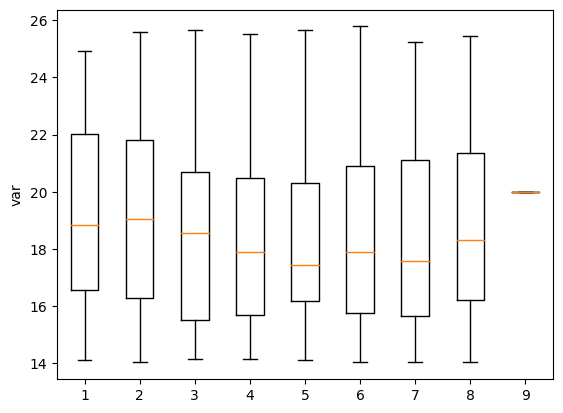

------------------------------------------------------------------------
Para Cuadrilla
########################################################################


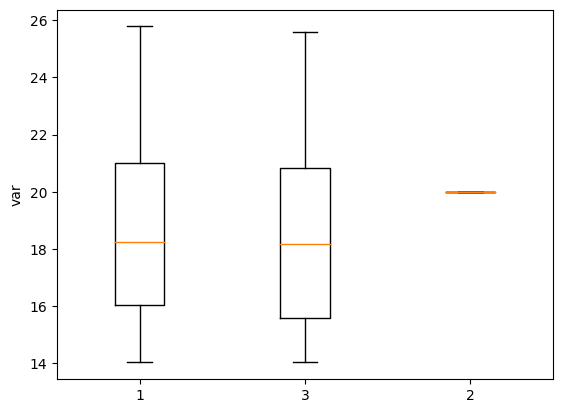

------------------------------------------------------------------------


In [ ]:
for i in ['intervalo','Cuadrilla']:
  print("Para "+i)
  print("####"*18)
  box(1,5,i,3)
  print("----"*18)

Para intervalo
########################################################################


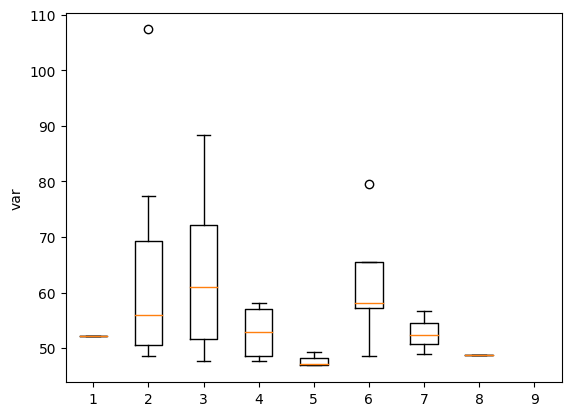

------------------------------------------------------------------------
Para Mes
########################################################################


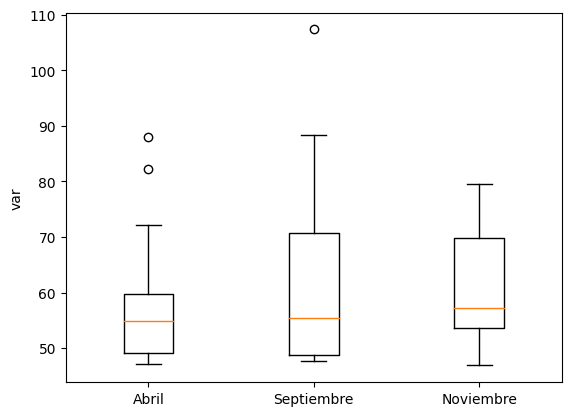

------------------------------------------------------------------------
Para dia
########################################################################


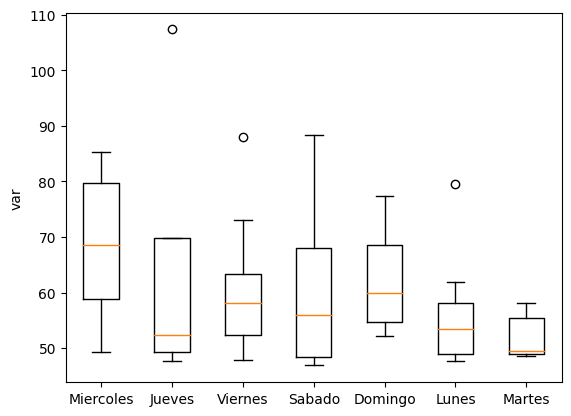

------------------------------------------------------------------------


In [ ]:
for i in ['intervalo','Mes','dia']:
  print("Para "+i)
  print("####"*18)
  box(1,5,i,4)
  print("----"*18)

##Gráfico que representa la densidad de los datos

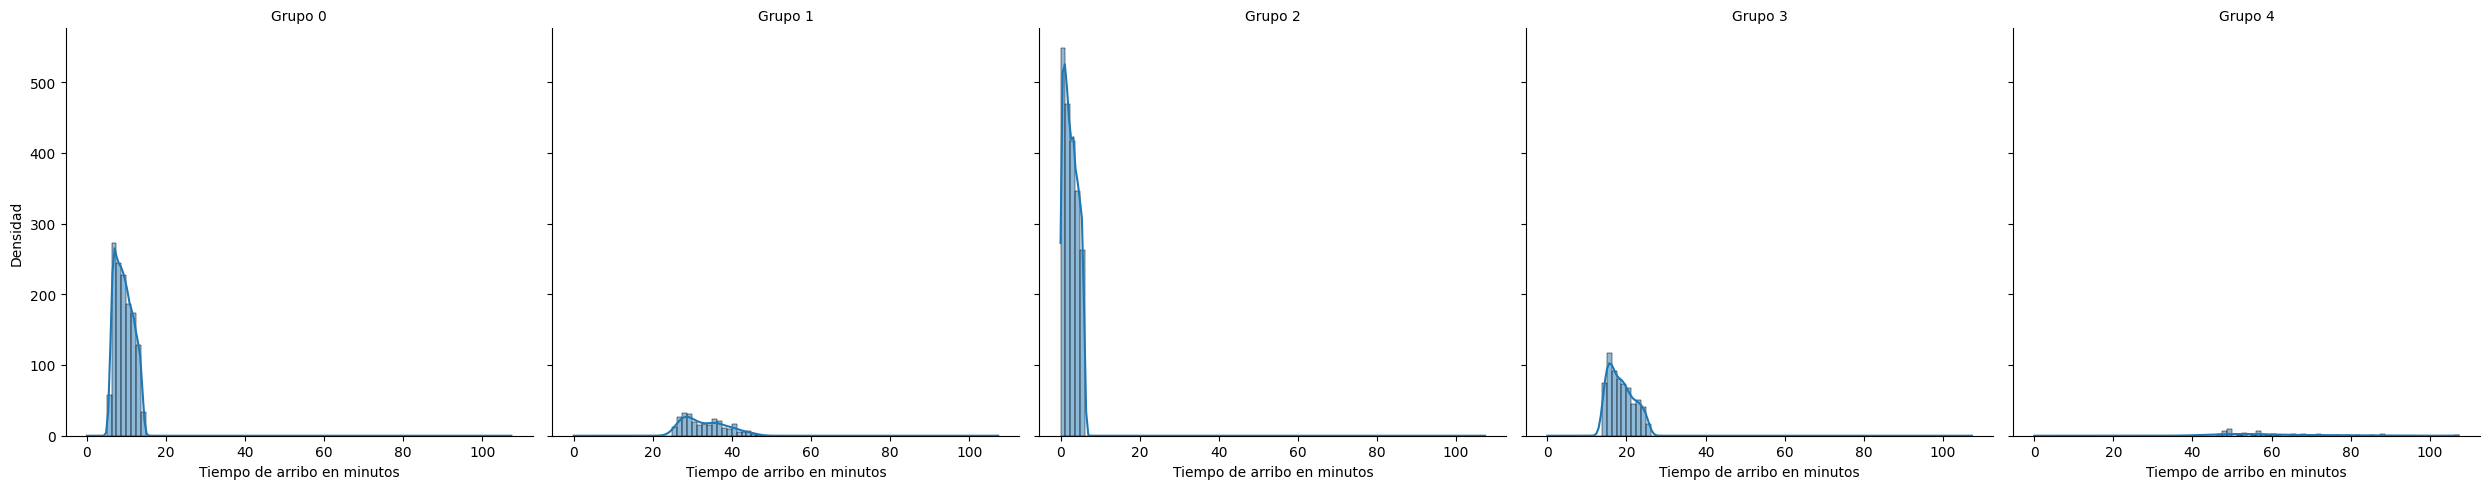

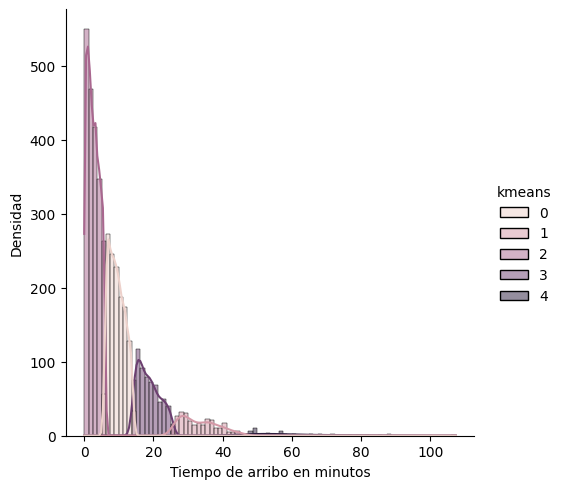

In [ ]:
grafica_densidad(1,5,100)
grafica_densidad_2(1,5,100)

##Para el turno 2

In [ ]:
resultados=kmeans_eval(2,[2,3,4,5,6,7,8])
print("**"*10)
print("Para el turno 2")
for i in [2,3,4,5,6,7,8]:
  print("%%%"*10)
  print("Para grupos de "+str(i))
  print("--"*10)
  print(resultados[(resultados['grupo'].apply(lambda x: x[0] == i))&(resultados['Independencia']==False)&(resultados['index']=="Kruskal")].dropna(axis=1))
  print("++"*10)
  print(resultados[(resultados['grupo'].apply(lambda x: x[0] == i))&(resultados['equal_var']==False)&(resultados['index']=="levene")].dropna(axis=1))
  print("--"*10)

********************
Para el turno 2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para grupos de 2
--------------------
     index     Source  ddof1          H     p-unc   grupo  turno Independencia
8  Kruskal  intervalo    6.0  34.699287  0.000005  (2, 0)      2         False
++++++++++++++++++++
Empty DataFrame
Columns: [index, Source, ddof1, H, p-unc, grupo, turno, Independencia, W, pval, equal_var, T]
Index: []
--------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para grupos de 3
--------------------
      index     Source  ddof1          H     p-unc   grupo  turno  \
23  Kruskal  intervalo    6.0  21.654536  0.001398  (3, 1)      2   

   Independencia  
23         False  
++++++++++++++++++++
      index Source   grupo  turno         W      pval equal_var
196  levene    dia  (3, 1)      2  2.856428  0.008922     False
--------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para grupos de 4
--------------------
      index     Source  ddof1          H     p-unc   grupo  turno  \
33  Kruskal  interva

###Prueba particular del turno y grupo casi acordes

In [ ]:
resultado=kmeans_eval(2,2,15)

In [ ]:
resultado[(resultado['index']=="Kruskal")].dropna(axis=1)

,index,Source,ddof1,H,p-unc,grupo,turno,Independencia
0,Kruskal,Mes,2.0,3.448259,0.178328,"(2, 1)",2,True
1,Kruskal,dia,6.0,4.762376,0.574631,"(2, 1)",2,True
2,Kruskal,TipoServ.,4.0,1.763259,0.779197,"(2, 1)",2,True
3,Kruskal,intervalo,5.0,9.461083,0.092027,"(2, 1)",2,True
4,Kruskal,Cuadrilla,1.0,0.608688,0.435282,"(2, 1)",2,True
5,Kruskal,Mes,2.0,0.314334,0.854561,"(2, 0)",2,True
6,Kruskal,dia,6.0,5.949979,0.428817,"(2, 0)",2,True
7,Kruskal,TipoServ.,4.0,3.337821,0.502962,"(2, 0)",2,True
8,Kruskal,intervalo,5.0,7.219432,0.204826,"(2, 0)",2,True
9,Kruskal,Cuadrilla,1.0,0.536161,0.464028,"(2, 0)",2,True


In [ ]:
resultado[(resultado['index']=="levene")].dropna(axis=1)

,index,Source,grupo,turno,W,pval,equal_var
14,levene,Mes,"(2, 1)",2,1.298190,0.273619,True
15,levene,dia,"(2, 1)",2,1.006395,0.419790,True
16,levene,TipoServ.,"(2, 1)",2,0.956379,0.430771,True
17,levene,intervalo,"(2, 1)",2,1.772224,0.116135,True
18,levene,Cuadrilla,"(2, 1)",2,1.587003,0.208134,True
19,levene,Mes,"(2, 0)",2,2.010583,0.134068,True
20,levene,dia,"(2, 0)",2,1.206217,0.299757,True
21,levene,TipoServ.,"(2, 0)",2,0.411338,0.800603,True
22,levene,intervalo,"(2, 0)",2,0.658698,0.654860,True
23,levene,Cuadrilla,"(2, 0)",2,2.651511,0.103543,True


In [ ]:
resultado[(resultado['index']=="bartlett")].dropna(axis=1)

,index,Source,grupo,turno,pval,equal_var,T
28,bartlett,Mes,"(2, 1)",2,0.043516,False,6.269240
29,bartlett,dia,"(2, 1)",2,0.060789,True,12.053337
30,bartlett,TipoServ.,"(2, 1)",2,0.071595,True,8.610942
31,bartlett,intervalo,"(2, 1)",2,0.000036,False,28.024549
32,bartlett,Cuadrilla,"(2, 1)",2,0.050167,True,3.835879
33,bartlett,Mes,"(2, 0)",2,0.147611,True,3.826354
34,bartlett,dia,"(2, 0)",2,0.585019,True,4.683343
35,bartlett,TipoServ.,"(2, 0)",2,0.796083,True,1.670426
36,bartlett,intervalo,"(2, 0)",2,0.735176,True,2.771416
37,bartlett,Cuadrilla,"(2, 0)",2,0.189597,True,1.720747


###Gráficas de densidad para turno 2 grupo 2

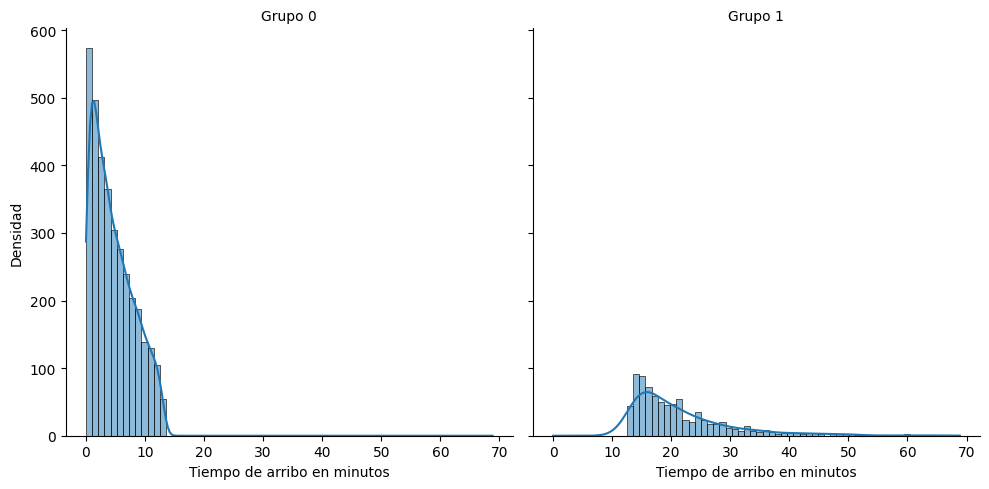

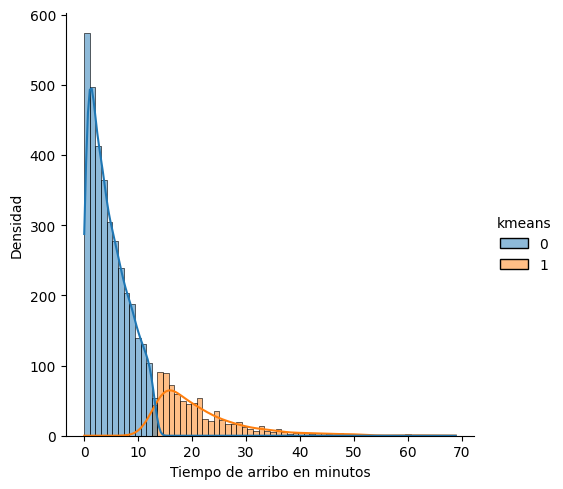

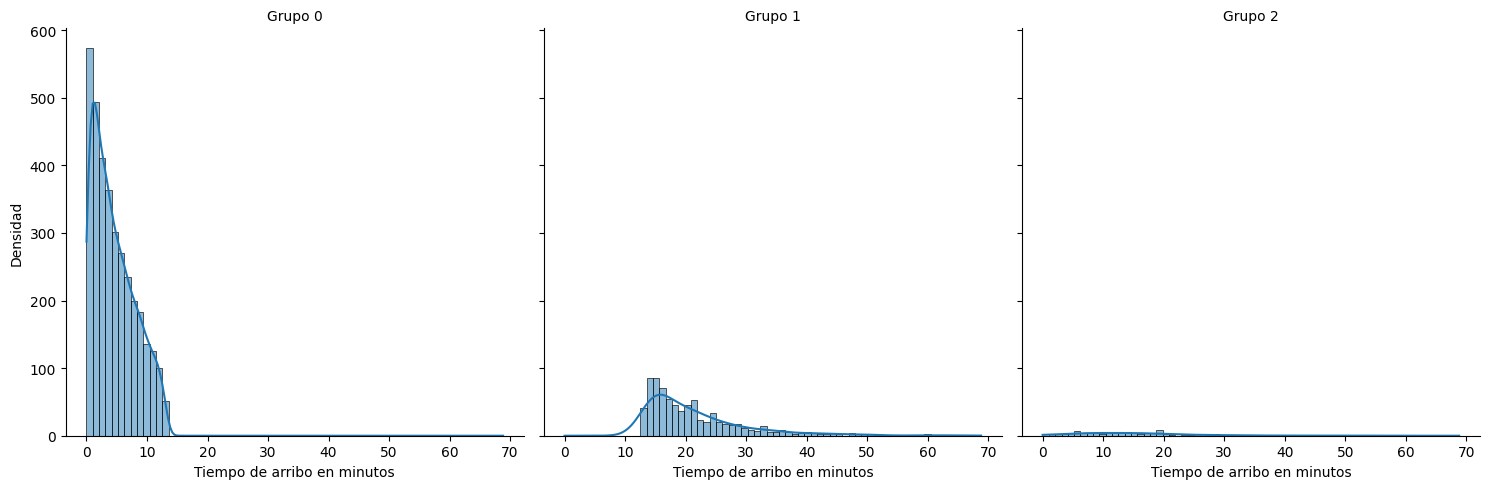

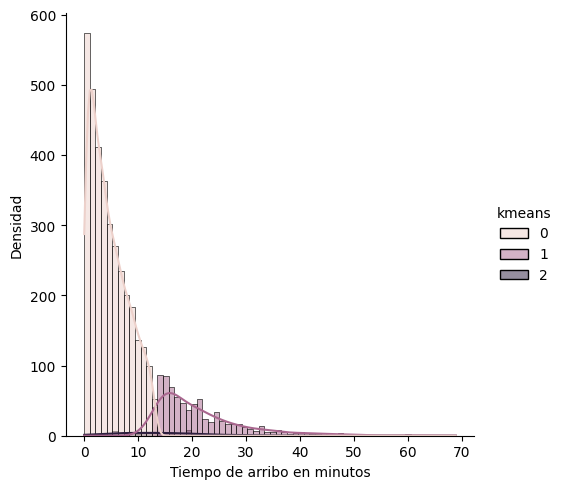

In [ ]:
grafica_densidad(2,2,100)
grafica_densidad_2(2,2,100)
grafica_densidad(2,2,15)
grafica_densidad_2(2,2,15)

##Gráfica de cajas y bigotes, turno 2 grupo de 2.
Se comprueba que es el intervalo 15 el que altera las pruebas, una de las razones es por que es una muestra no robusta ya que unicamente toma tiempos de 30 min para sacar sus arribos.

Primer grupo
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$


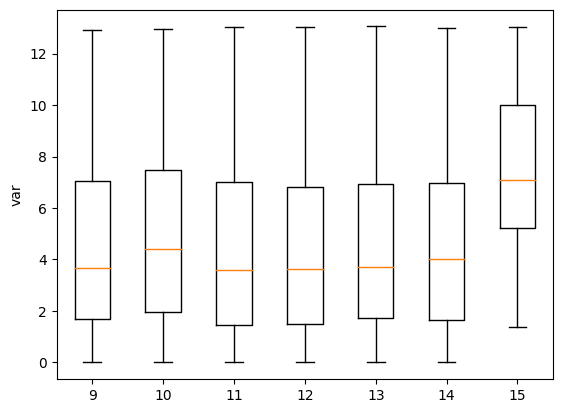

Segundo grupo
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$


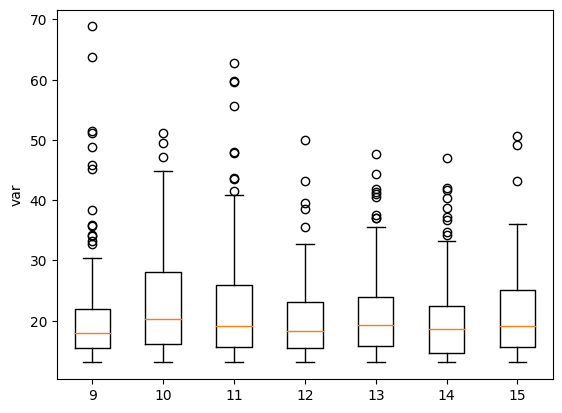

In [ ]:
print("Primer grupo")
print("$$$$"*18)
box(2,2,"intervalo",0)
print("Segundo grupo")
print("$$$$"*18)
box(2,2,"intervalo",1)

In [ ]:
arribo['Llegada'].max()

Timestamp('1900-01-01 20:33:16')

#Graficas

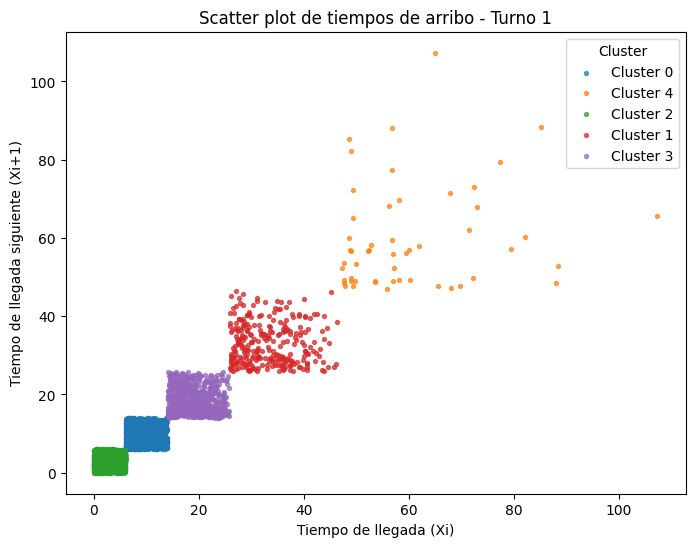

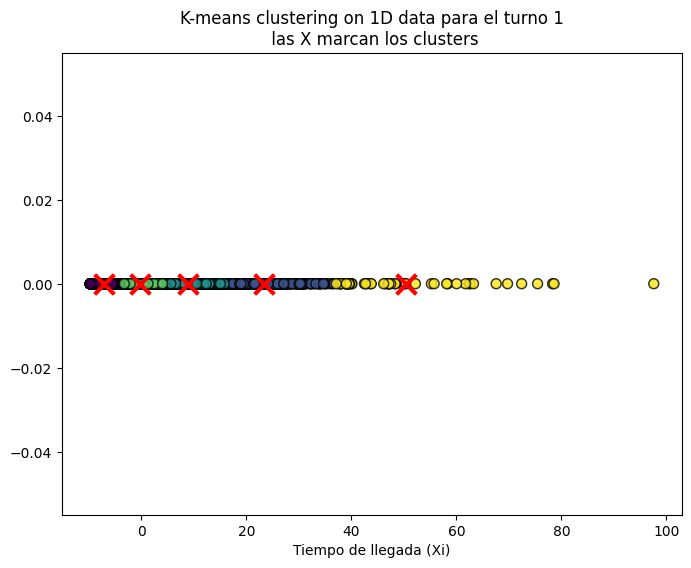

In [ ]:
dispercion(1,5)
grafica1d(1,5)

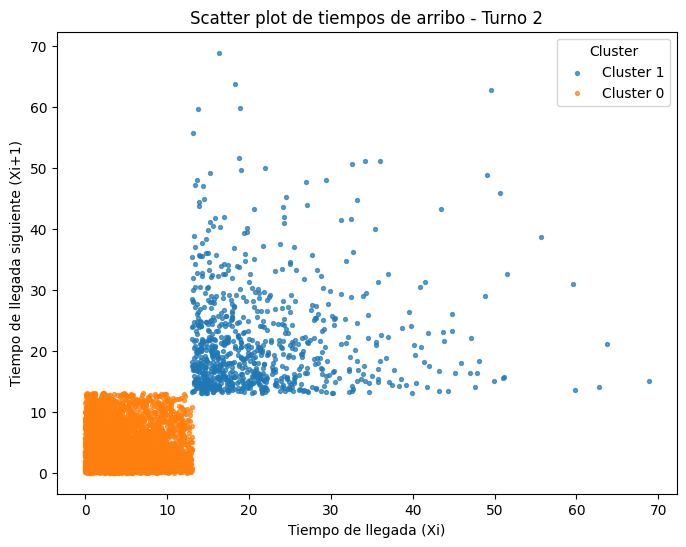

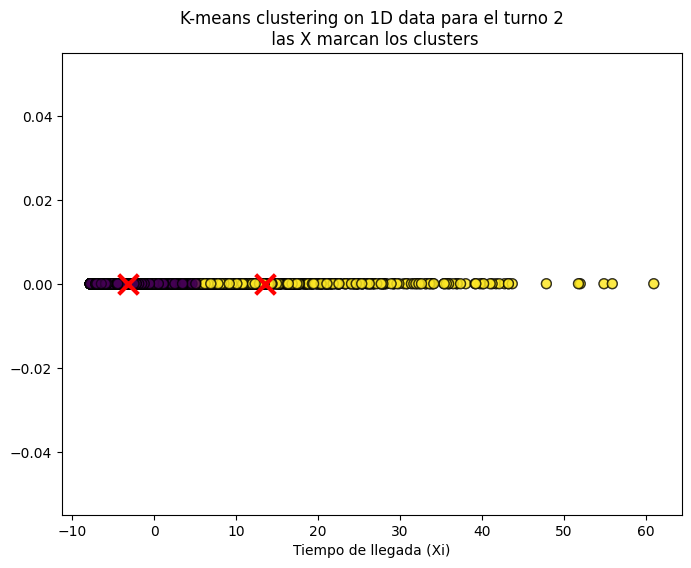

In [ ]:
dispercion(2,2)
grafica1d(2,2)

#Corrigiendo el clustering de intervalo para el grupo 0 para que de kruskal True, en el turno 2


In [ ]:
kruskal,levene,pruebavar=pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
arreglo=[]
sorce=[]

base=arribo[(arribo['Turno']==2)]
base=base.reset_index()
X = np.array(base['min_cliente']).reshape(-1, 1)
df=pd.DataFrame()
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)
base['kmeans'] = kmeans.labels_

base=base[(base['kmeans']==0)]
base=base.reset_index()

X = np.array(base['min_cliente']).reshape(-1, 1)
df=pd.DataFrame()

for k in [2,3,4,5,6,7,8,9,10,11,12]:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(X)
  df[k] = kmeans.labels_

cosas=["Mes","dia","TipoServ.","intervalo","Cuadrilla"]

for k in list(df.columns):
  base['kmeans']=df[k]

  for i in base['kmeans'].unique():
    eval=base[(base['kmeans']==i)]

    for j in cosas:
      if len(eval[j].unique())>1:
        mete=(k,i)
        sorce.append(j)
        arreglo.append(mete)
        kruskal=pd.concat([kruskal,pg.kruskal(eval, dv='min_cliente', between=j)])
        levene=pd.concat([levene,pd.DataFrame(pg.homoscedasticity(eval, dv="min_cliente", group=j))])
        pruebavar=pd.concat([pruebavar,pg.homoscedasticity(eval, dv="min_cliente", group=j, method="bartlett", alpha=.05)])

kruskal['grupo']=arreglo
levene['grupo']=arreglo
pruebavar['grupo']=arreglo
result=[]
for i in kruskal['p-unc']:
  if i<=5e-02:
    result.append(False)
  else:
    result.append(True)
kruskal["Independencia"]=result
levene['Source']=sorce

In [ ]:
for i in [2,3,4,5,6,7,8,9,10,11,12]:
  print("%%%"*10)
  print("Para grupos de "+str(i))
  print("--"*10)
  print(kruskal[(kruskal['grupo'].apply(lambda x: x[0] == i))&(kruskal['Independencia']==False)])
  print("++"*10)
  print(levene[(levene['grupo'].apply(lambda x: x[0] == i))&(levene['equal_var']==False)])
  print("--"*10)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para grupos de 2
--------------------
            Source  ddof1          H     p-unc   grupo  Independencia
Kruskal  intervalo      6  16.365988  0.011919  (2, 1)          False
Kruskal        dia      6  12.748099  0.047215  (2, 0)          False
++++++++++++++++++++
Empty DataFrame
Columns: [W, pval, equal_var, grupo, Source]
Index: []
--------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para grupos de 3
--------------------
Empty DataFrame
Columns: [Source, ddof1, H, p-unc, grupo, Independencia]
Index: []
++++++++++++++++++++
               W      pval  equal_var   grupo     Source
levene  2.592536  0.016871      False  (3, 1)        dia
levene  6.518627  0.010808      False  (3, 1)  Cuadrilla
--------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para grupos de 4
--------------------
            Source  ddof1         H     p-unc   grupo  Independencia
Kruskal  Cuadrilla      1  5.616899  0.017788  (4, 0)          False
++++++++++++++++++++
Empty DataFrame

###Para el grupo 4, el conjunto 0 en cuadrilla


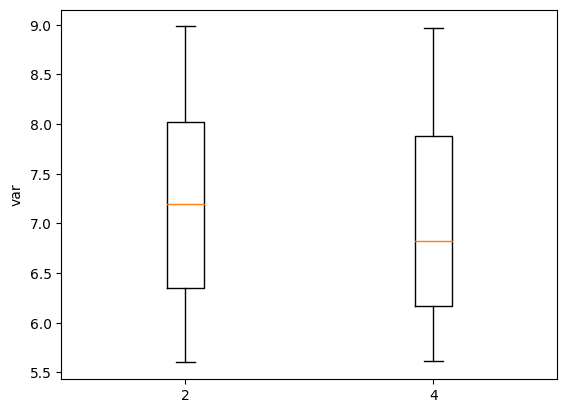

In [ ]:
box(2,4,"Cuadrilla",0)

###Para el grupo cinco, el conjunto día 3

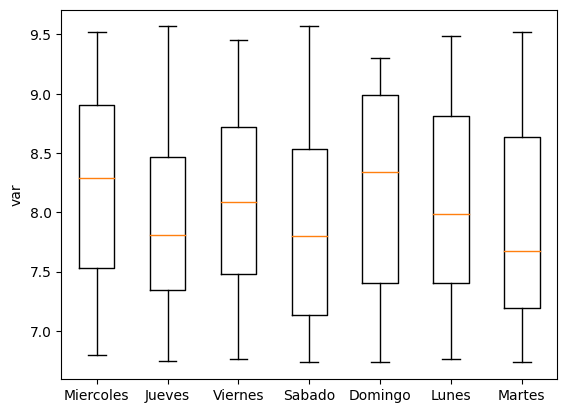

In [ ]:
box(2,5,"dia",3)

#Sacando las fit


##Para el turno 1, 5 diferentes

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.0269173] [loc=9.444 scale=2.242]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.0248178] [loc=6.050 scale=3.394]
[distfit] >INFO> [pareto    ] [0.01 sec] [RSS: 0.0248178] [loc=-268435449.950 scale=268435456.000]
[distfit] >INFO> [dweibull  ] [0.08 sec] [RSS: 0.0361251] [loc=9.655 scale=2.134]
[distfit] >INFO> [t         ] [0.60 sec] [RSS: 0.0269183] [loc=9.444 scale=2.242]
[distfit] >INFO> [genextreme] [0.07 sec] [RSS: 0.0227742] [loc=8.519 scale=2.007]
[distfit] >INFO> [gamma     ] [0.05 sec] [RSS: 0.015343] [loc=5.811 scale=1.846]
[distfit] >INFO> [lognorm   ] [0.00 sec] [RSS: 0.0209869] [loc=2.497 scale=6.584]
[distfit] >INFO> [beta      ] [0.12 sec] [RSS: 0.00137391] [loc=6.050 scale=7.998]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0128562] [loc=6.050 scale=7.967]
[distfit] >INFO> [loggamma  ] [0.06 sec] [RSS: 0.0264912] [loc=-664.731 scale=91.234]
[distfit] >INFO> fit
[distfit

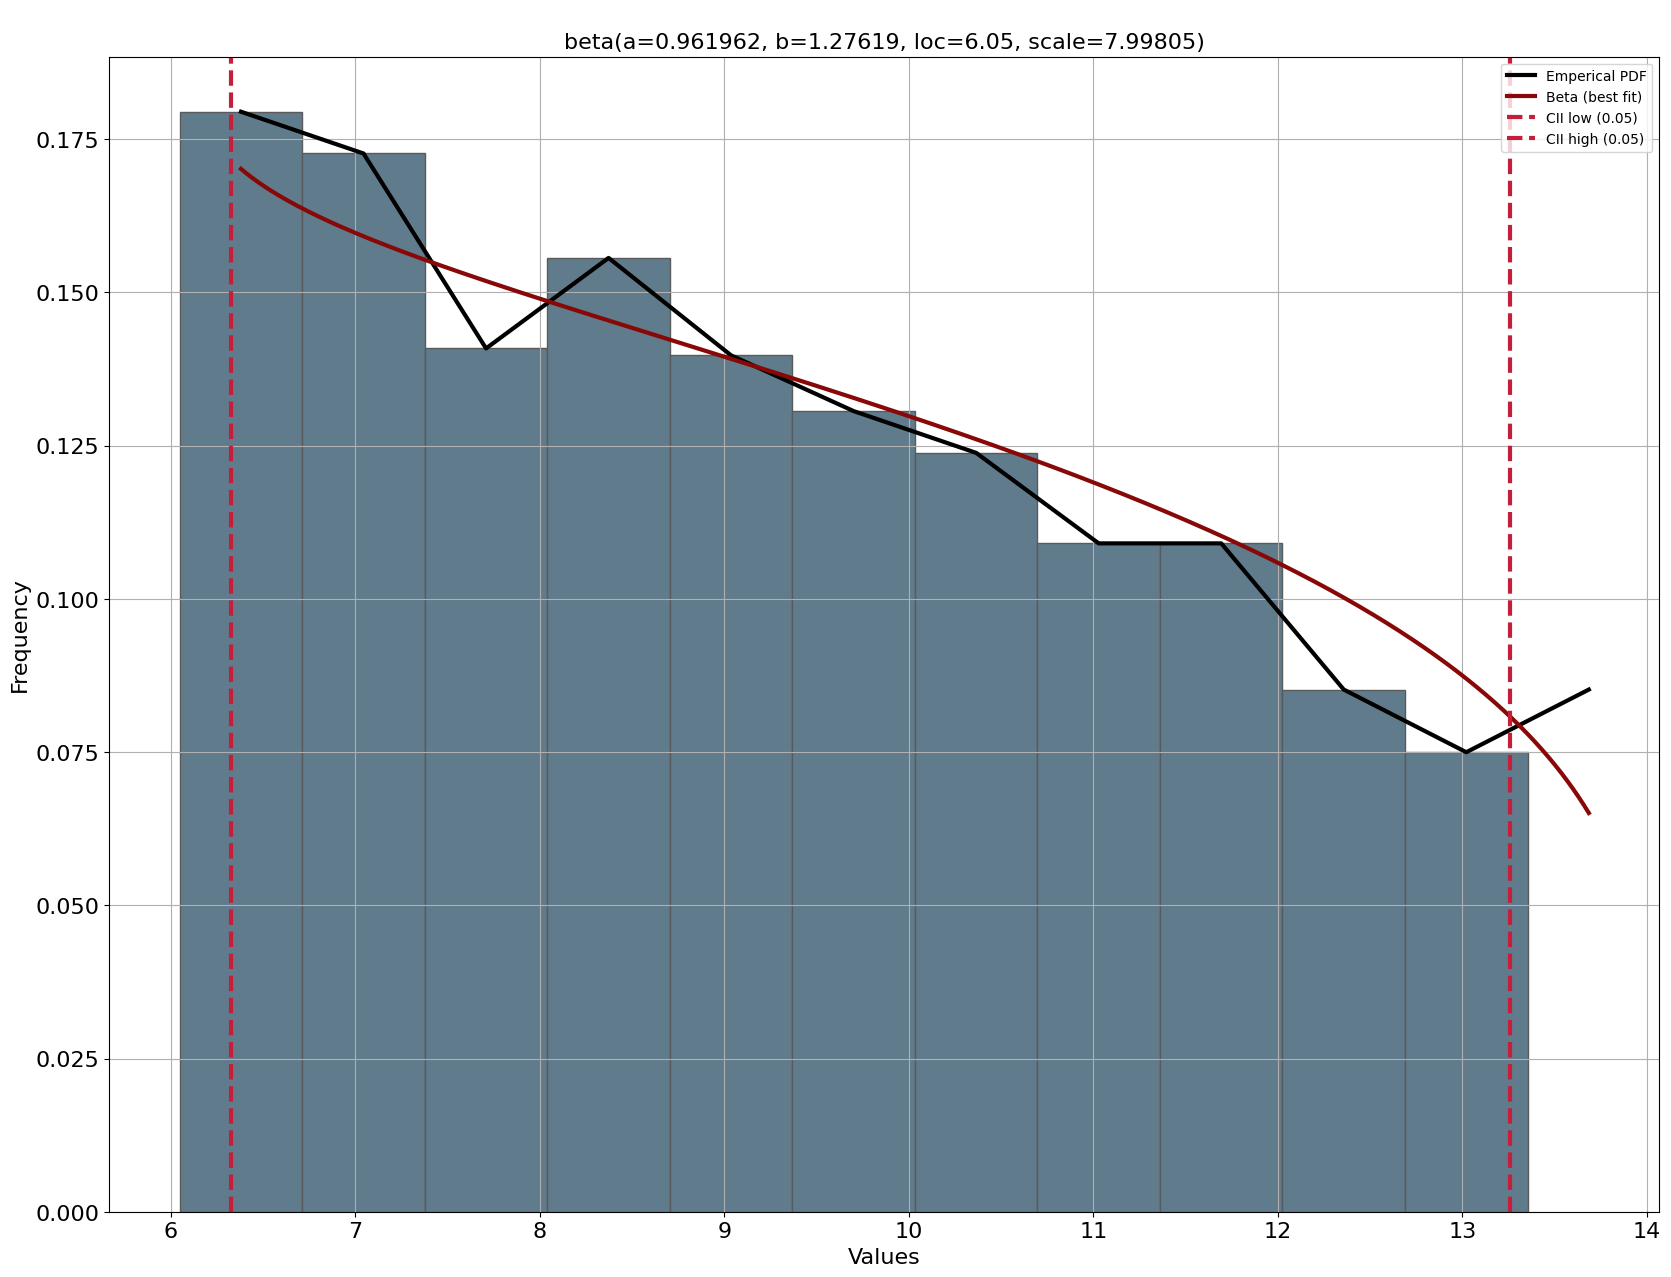

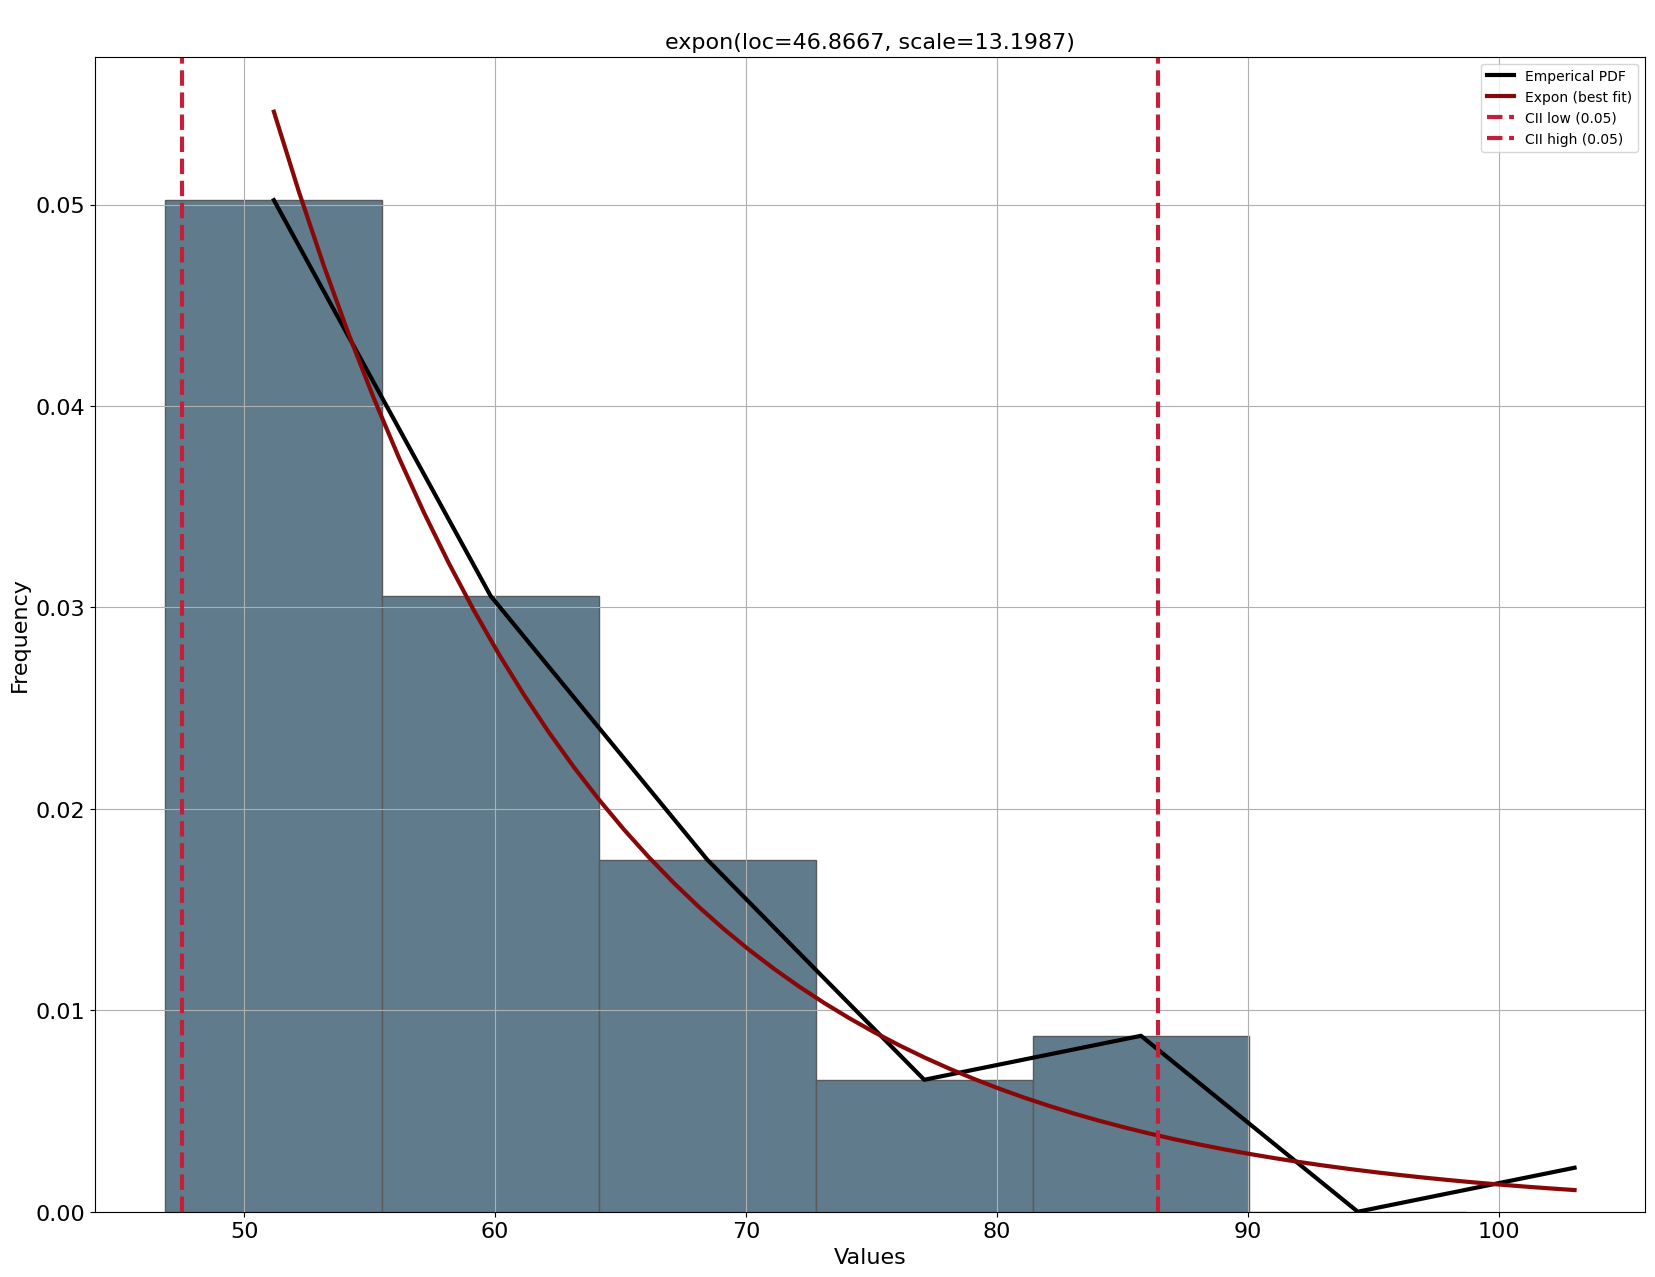

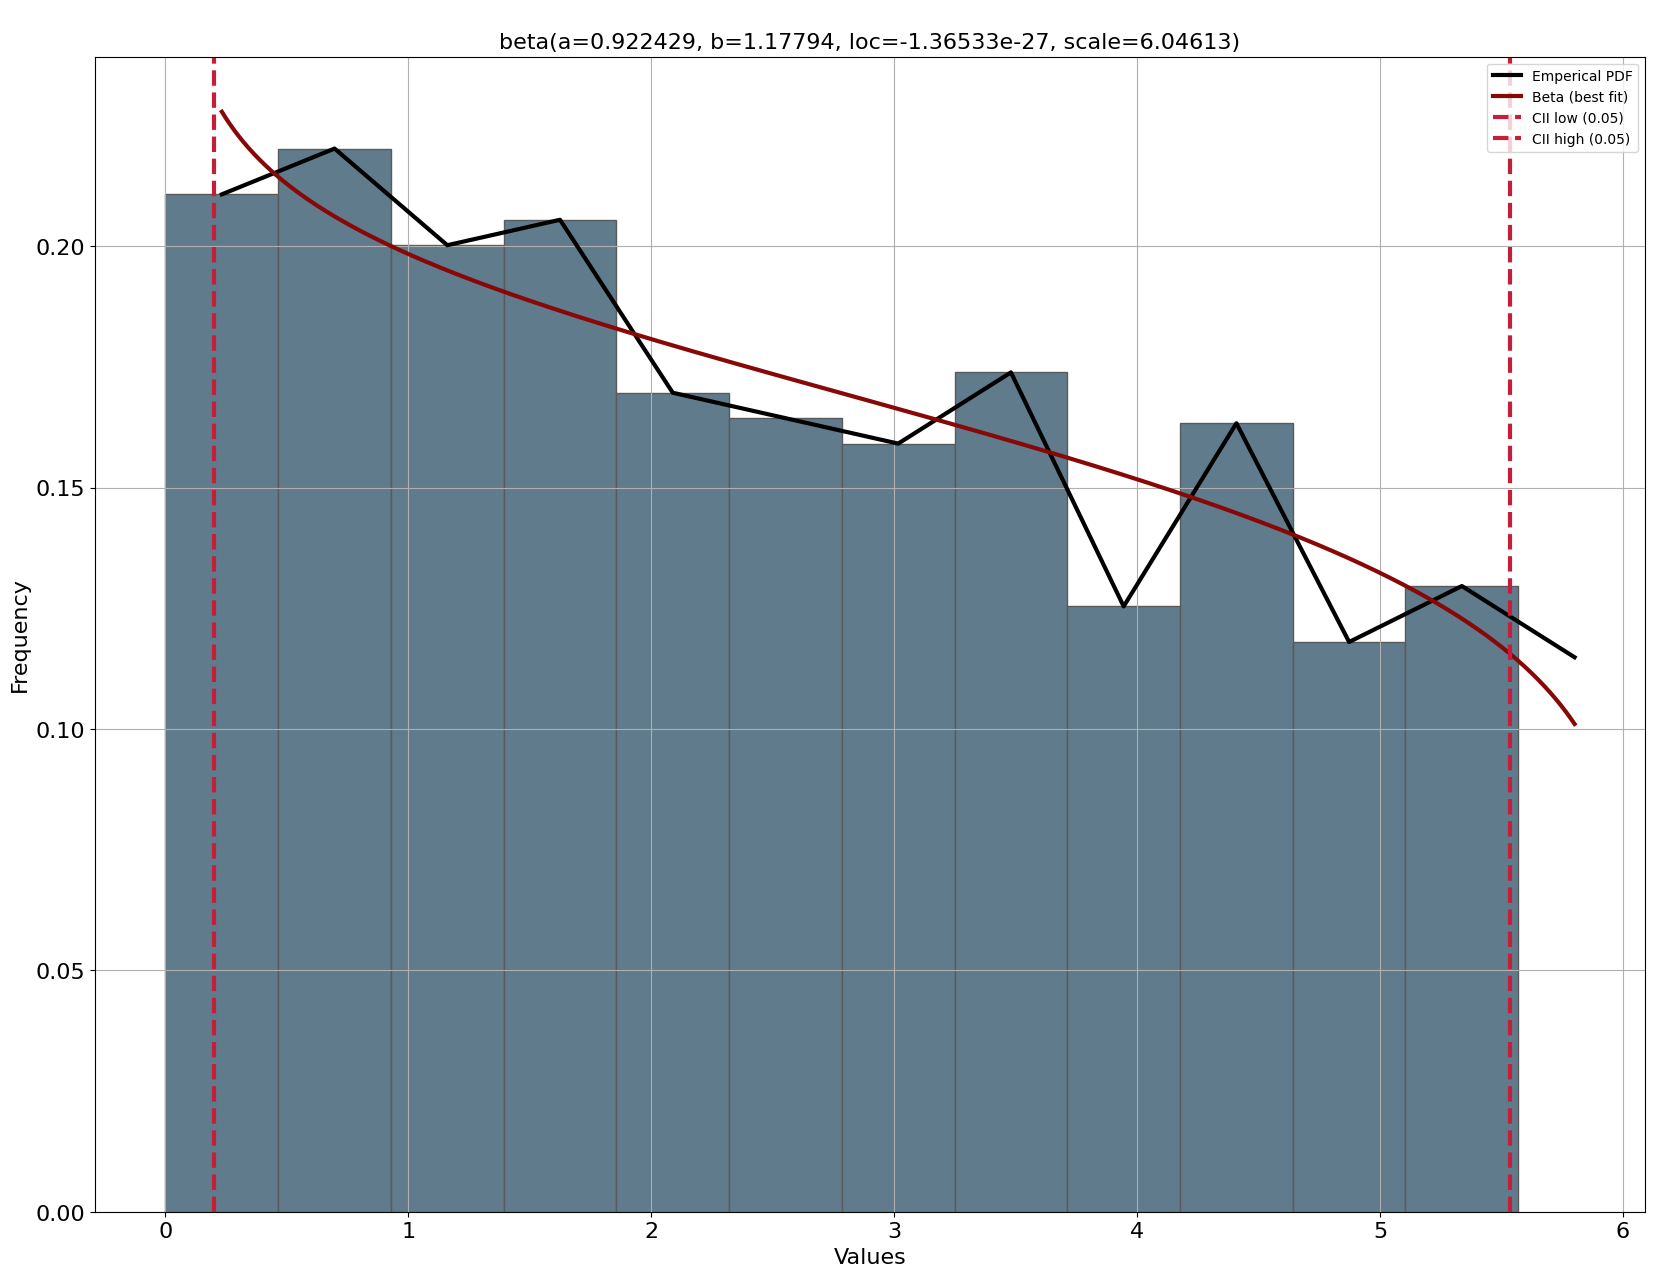

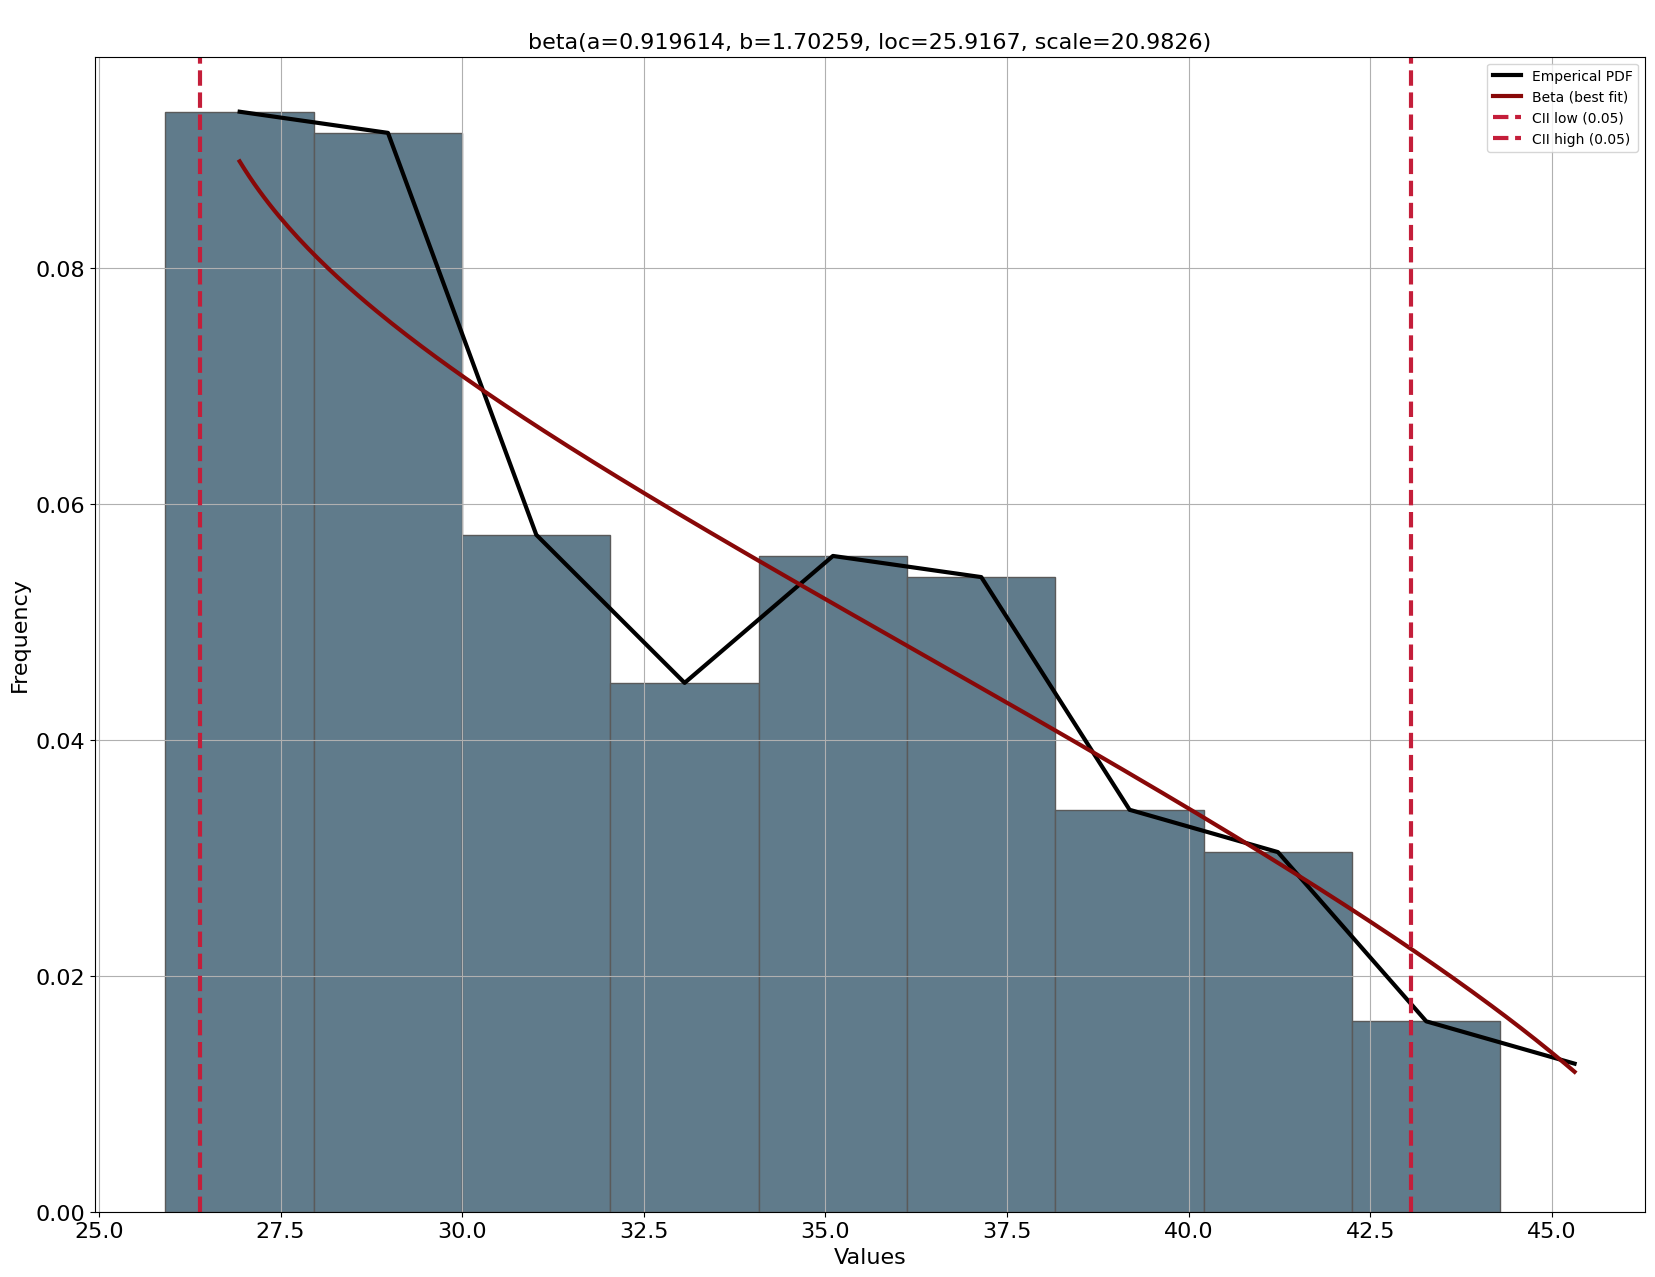

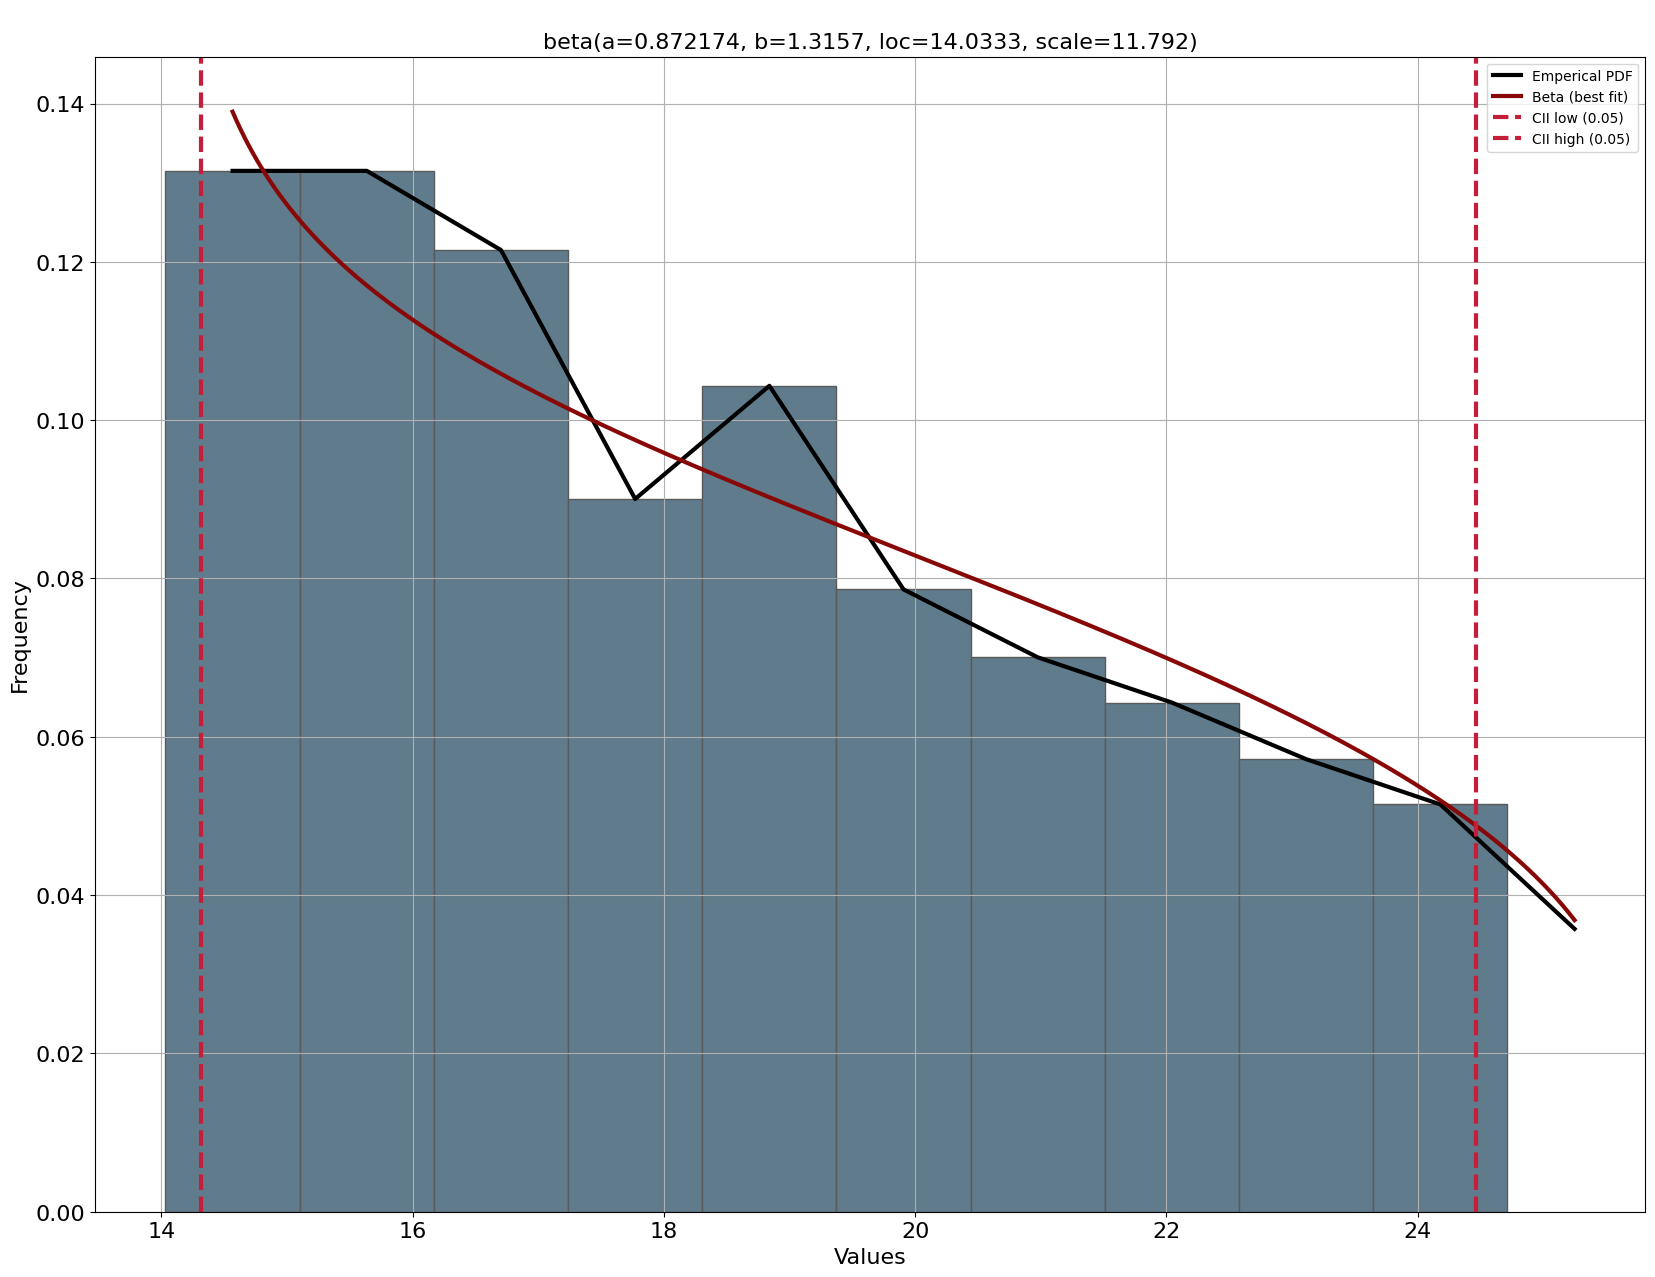

In [ ]:
fit(1,5,9)

In [ ]:
cosas=["Mes","dia","TipoServ.","Servidor","Cuadrilla"]
for i in cosas:
  print("%%%%"*10)
  print("Para "+i)
  print("$$$"*10)
  print("Los valores normales regulares, es decir, el conteo")
  print("---"*10)
  print(pd.crosstab(base['kmeans'],base[i]))
  print("$$$"*10)
  print("Los valores de representación ocurrencia, es decir, el porcentaje")
  print("---"*10)
  print(pd.crosstab(base['kmeans'],base[i],normalize='index'))

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para Mes
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Los valores normales regulares, es decir, el conteo
------------------------------
Mes     Abril  Noviembre  Septiembre
kmeans                              
0         439        429         458
1          93        105          75
2         675        643         727
3         209        203         244
4          22         17          14
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Los valores de representación ocurrencia, es decir, el porcentaje
------------------------------
Mes        Abril  Noviembre  Septiembre
kmeans                                 
0       0.331071   0.323529    0.345400
1       0.340659   0.384615    0.274725
2       0.330073   0.314425    0.355501
3       0.318598   0.309451    0.371951
4       0.415094   0.320755    0.264151
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para dia
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Los valores normales regulares, es decir, el conteo
------------------------------
dia  

###Para turno 2, tres diferentes, dos de grupo grande, una grupo chico.

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.00994228] [loc=21.455 scale=8.468]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.000199774] [loc=13.067 scale=8.388]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.000195046] [loc=-783.273 scale=796.340]
[distfit] >INFO> [dweibull  ] [0.03 sec] [RSS: 0.00746975] [loc=19.380 scale=6.063]
[distfit] >INFO> [t         ] [0.49 sec] [RSS: 0.00662457] [loc=18.979 scale=4.866]
[distfit] >INFO> [genextreme] [0.13 sec] [RSS: 0.00146568] [loc=16.811 scale=3.801]
[distfit] >INFO> [gamma     ] [0.09 sec] [RSS: 0.000196394] [loc=13.067 scale=8.626]
[distfit] >INFO> [lognorm   ] [0.00 sec] [RSS: 0.00060202] [loc=12.525 scale=5.791]
[distfit] >INFO> [beta      ] [0.16 sec] [RSS: 0.000205258] [loc=13.067 scale=507.787]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.02206] [loc=13.067 scale=55.767]
[distfit] >INFO> [loggamma  ] [0.11 sec] [RSS: 0.0101476] [loc=-4067.614 scale=505.111]
[distfit] >INFO>

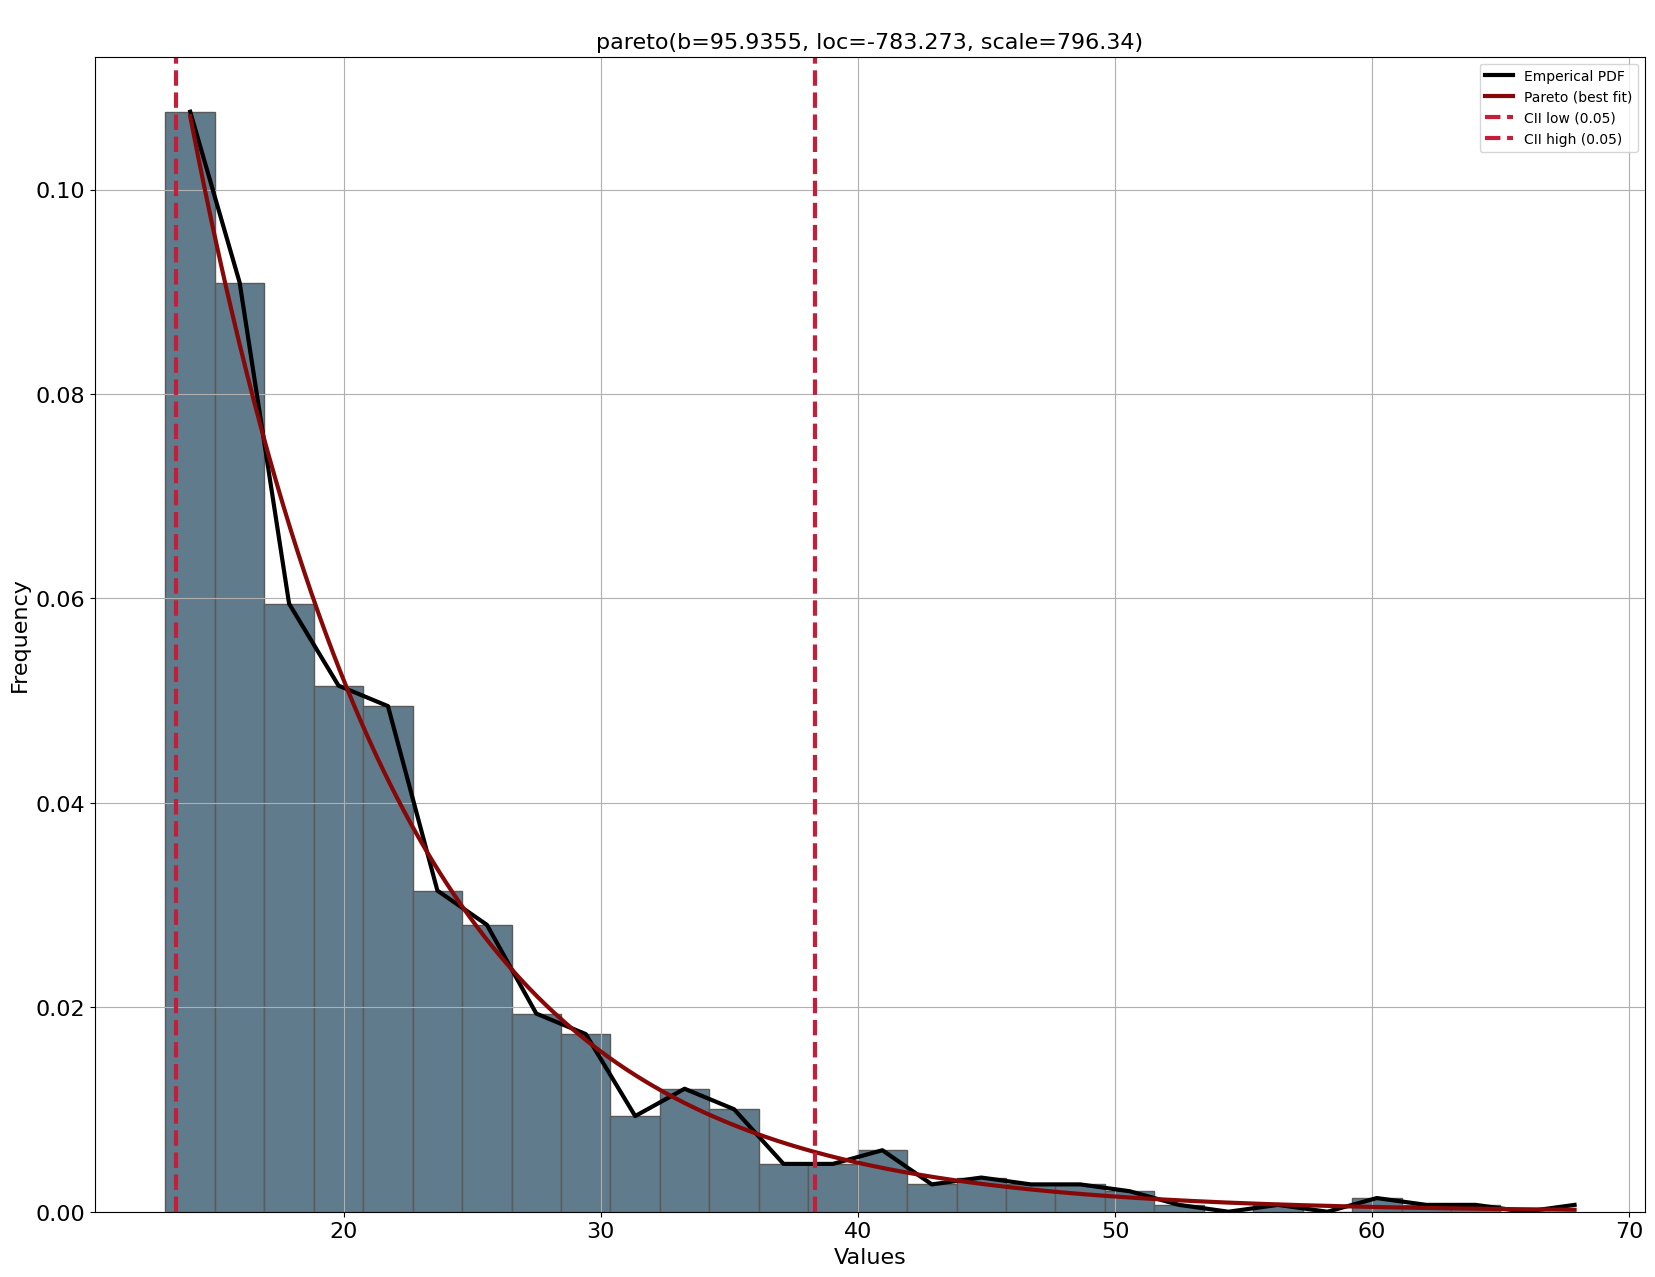

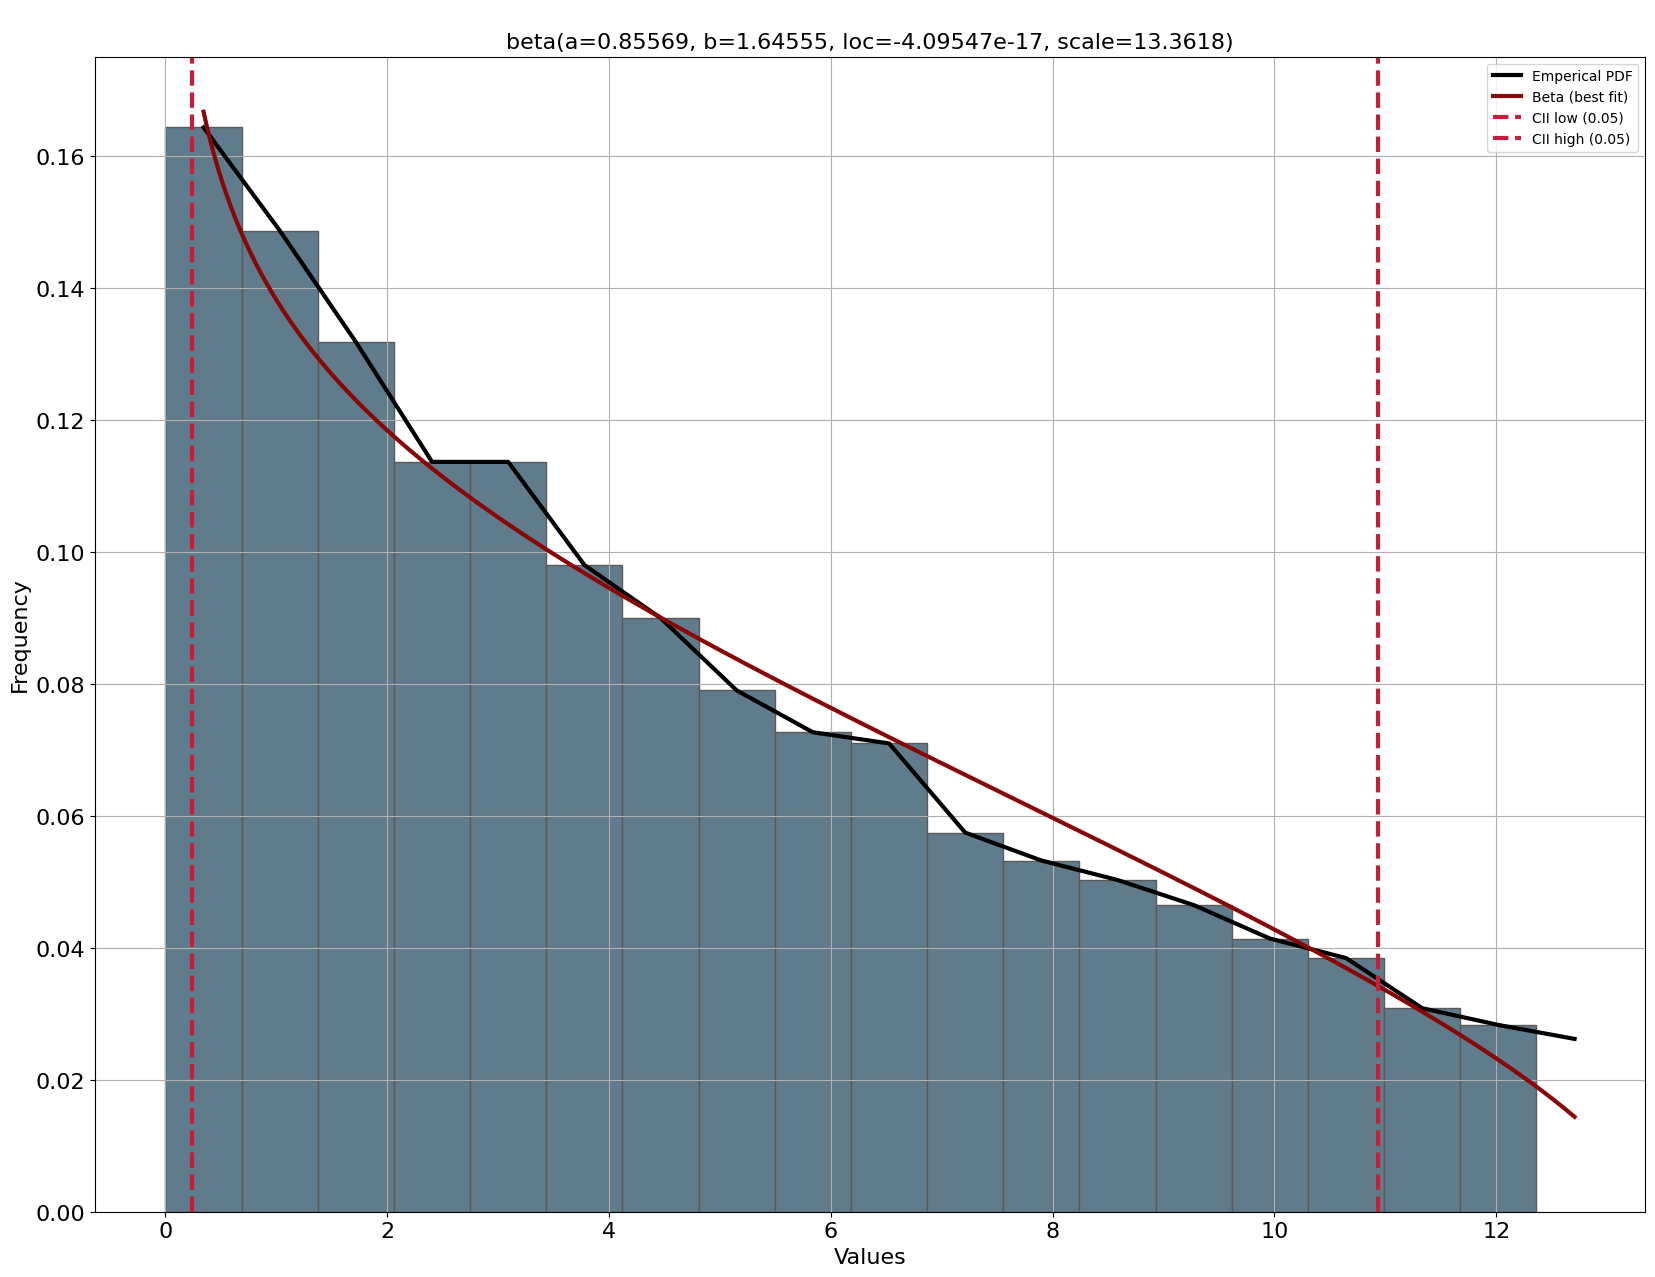

In [ ]:
fit(2,2,15)

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.000861077] [loc=14.839 scale=9.778]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00116346] [loc=1.367 scale=13.472]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.00116346] [loc=-536870910.633 scale=536870912.000]
[distfit] >INFO> [dweibull  ] [0.01 sec] [RSS: 0.000608104] [loc=13.583 scale=7.463]
[distfit] >INFO> [t         ] [0.21 sec] [RSS: 0.000636654] [loc=13.323 scale=7.072]
[distfit] >INFO> [genextreme] [0.07 sec] [RSS: 0.000538983] [loc=10.161 scale=6.663]
[distfit] >INFO> [gamma     ] [0.01 sec] [RSS: 0.000377705] [loc=0.525 scale=6.778]
[distfit] >INFO> [lognorm   ] [0.00 sec] [RSS: 0.000479197] [loc=-3.605 scale=16.204]
[distfit] >INFO> [beta      ] [0.05 sec] [RSS: 0.000369229] [loc=0.662 scale=367.881]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0032982] [loc=1.367 scale=49.250]
[distfit] >INFO> [loggamma  ] [0.05 sec] [RSS: 0.00087769] [loc=-2980.413 scale=404.165]


(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\nbeta(a=1.97592, b=49.2988, loc=0.662212, scale=367.881)'}, xlabel='Values', ylabel='Frequency'>)

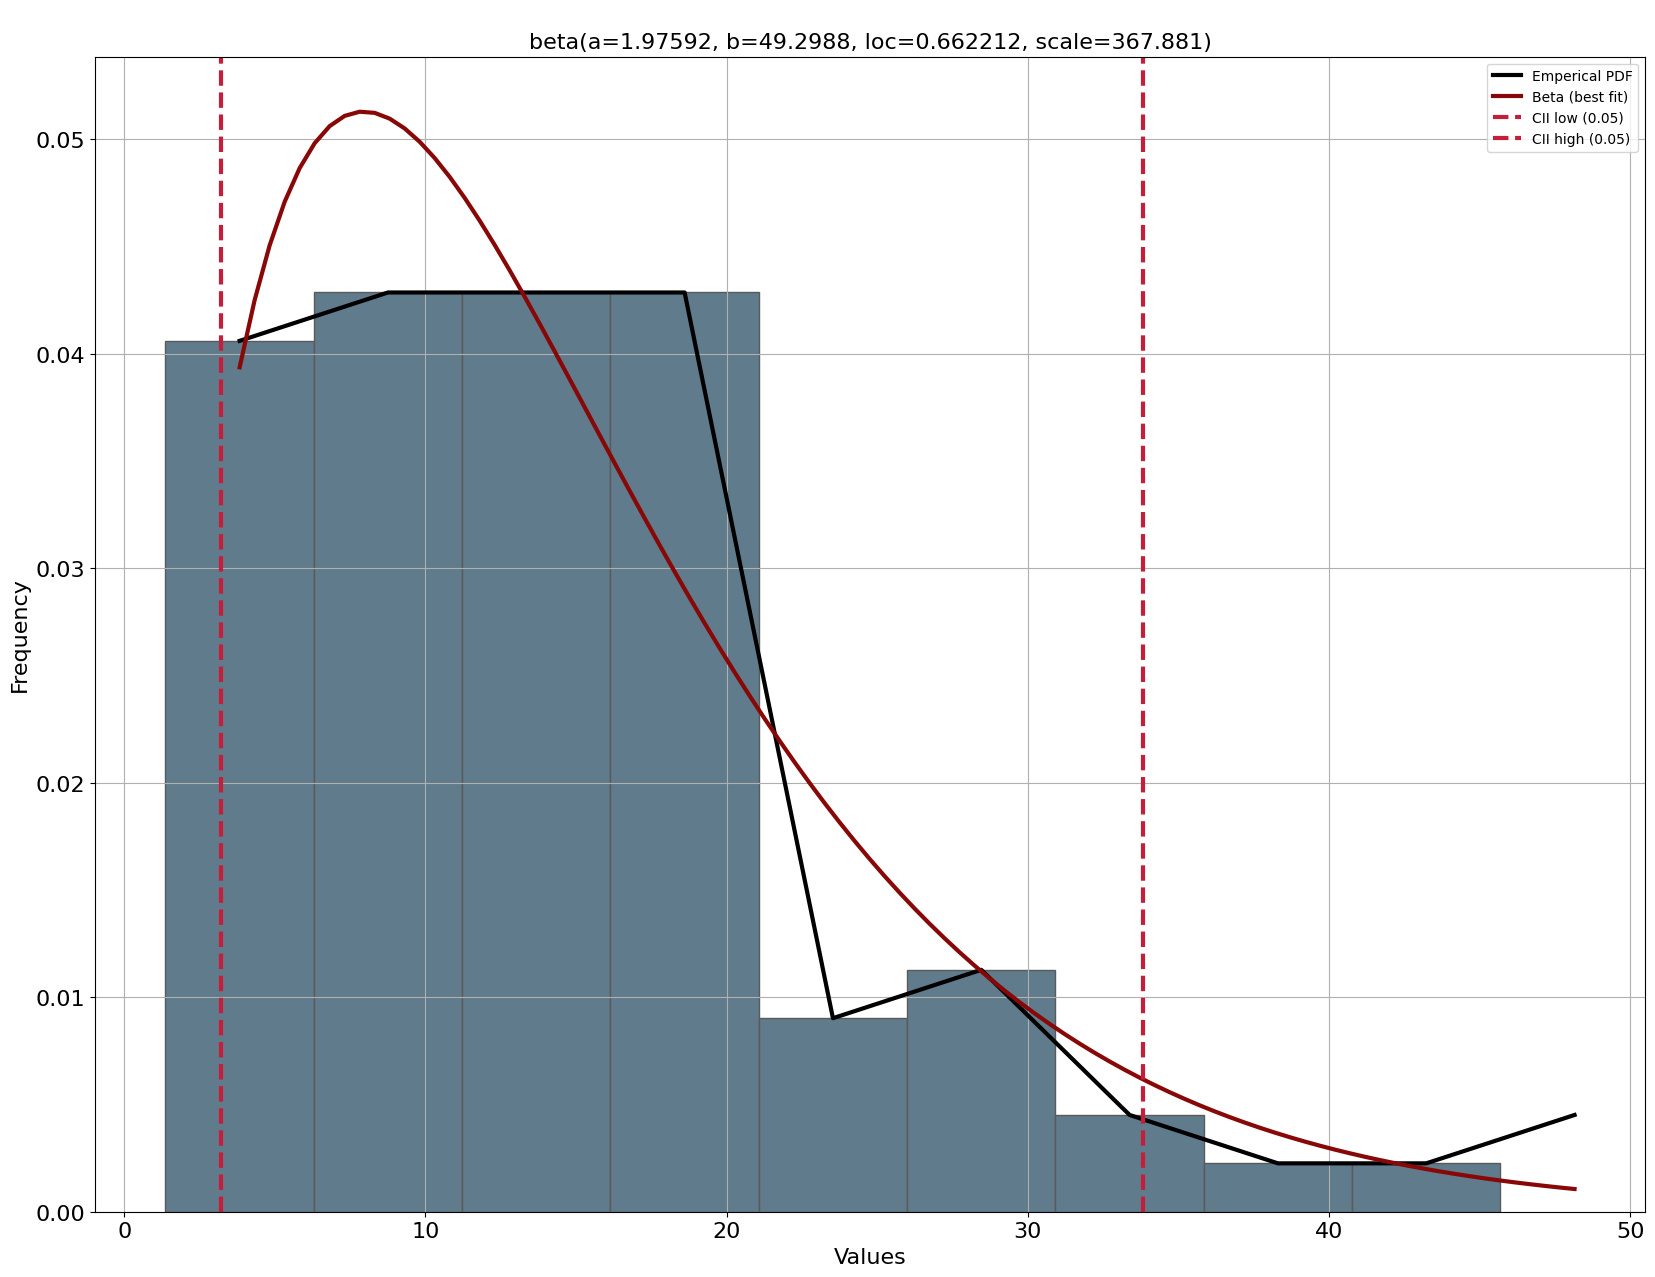

In [ ]:
dfit = distfit()
results2 = dfit.fit_transform(arribo[(arribo['intervalo']==15)]['min_cliente'])
results2['summary'].to_excel("grupo_intervalo_15.xlsx")
dfit.plot()

#Realizando Gauss para determinar kmeans, nada concluyente


In [ ]:
cosas=["dia","TipoServ.","intervalo","Mes","Cuadrilla"]
kruskal,levene,pruebavar=pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
arreglo=[]
sorce=[]
turno=[]

for t in [1,2]:
  base=arribo[(arribo['Turno']==t)]
  base=base.reset_index()
  X = base[['min_cliente','num_mes','intervalo','tipo_serv','num_dia','dia_mes','Cuadrilla']]

  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  df=pd.DataFrame()
  for n_components in [2,3,4,5,6,7,8,9,10,11,12,13,14]:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_scaled)

    # Obtener las etiquetas predichas
    labels = gmm.predict(X_scaled)

    # Agregar las etiquetas al DataFrame original
    df[n_components] = labels


  for k in list(df.columns):
    base['kmeans']=df[k]

    for i in base['kmeans'].unique():
      eval=base[(base['kmeans']==i)]

      for j in cosas:
        if len(eval[j].unique())>1:
          mete=(k,i)
          sorce.append(j)
          turno.append(t)
          arreglo.append(mete)
          kruskal=pd.concat([kruskal,pg.kruskal(eval, dv='min_cliente', between=j)])
          levene=pd.concat([levene,pd.DataFrame(pg.homoscedasticity(eval, dv="min_cliente", group=j))])
          pruebavar=pd.concat([pruebavar,pg.homoscedasticity(eval, dv="min_cliente", group=j, method="bartlett", alpha=.05)])

kruskal['grupo']=arreglo
levene['grupo']=arreglo
pruebavar['grupo']=arreglo
kruskal['turno']=turno
levene['turno']=turno
pruebavar['turno']=turno
kruskal["Independencia"] = kruskal['p-unc'] <= 0.05
levene['Source']=sorce

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:2902: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 + 1.0/(3*(k - 1)) * ((np.sum(1.0/(Ni - 1.0), axis=0)) -
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:2902: RuntimeWarning: div

In [ ]:
for t in [1,2]:
  print("$$$$"*10)
  print("Para el turno "+str(t))
  for i in [2,3,4,5,6,7,8,9,10,11,12,13,14]:
    print("%%%"*10)
    print("Para grupos de "+str(i))
    print("--"*10)
    print(kruskal[(kruskal['grupo'].apply(lambda x: x[0] == i))&(kruskal['Independencia']==False)&(kruskal['turno']==t)])
    print("++"*10)
    print(levene[(levene['grupo'].apply(lambda x: x[0] == i))&(levene['equal_var']==False)&(levene['turno']==t)])
    print("--"*10)

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Para el turno 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Para grupos de 2
--------------------
            Source  ddof1         H     p-unc   grupo  turno  Independencia
Kruskal        dia      4  2.831563  0.586397  (2, 0)      1          False
Kruskal  TipoServ.      4  3.487359  0.479803  (2, 0)      1          False
Kruskal        Mes      2  0.120702  0.941434  (2, 0)      1          False
Kruskal  Cuadrilla      1  1.731680  0.188196  (2, 0)      1          False
Kruskal        dia      1  1.085045  0.297572  (2, 1)      1          False
Kruskal  TipoServ.      4  8.239910  0.083175  (2, 1)      1          False
Kruskal        Mes      2  5.580851  0.061395  (2, 1)      1          False
++++++++++++++++++++
               W          pval  equal_var   grupo  turno     Source
levene  6.611693  1.338105e-08      False  (2, 0)      1  intervalo
levene  4.424761  7.332107e-05      False  (2, 1)      1  intervalo
--------------------
%%%%%%%%%%%%%%%%%%%%